<a href="https://colab.research.google.com/github/Haebuk/Python_Machine_Learning/blob/master/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9%EC%8B%9D%EC%88%98%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from copy import deepcopy
!pip install -U gensim -q
from gensim.models import Word2Vec, FastText
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl

!pip install lightgbm --install-option=--gpu
# ! git clone --recursive https://github.com/Microsoft/LightGBM
# ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
!pip install optuna -q
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras

     |████████████████████████████████| 23.9MB 72.4MB/s 


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


     |████████████████████████████████| 166.7MB 37kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 307kB 4.3MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 174kB 43.8MB/s 
     |████████████████████████████████| 112kB 42.2MB/s 
     |████████████████████████████████| 143kB 40.8MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 


# 파일 로드

In [2]:
PATH = '/content/drive/MyDrive/input/235743_구내식당 식사 인원 예측 AI 경진대회_data/'
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')

In [3]:
train_df.iloc[204, :]

일자                                                       2016-11-30
요일                                                                수
본사정원수                                                          2689
본사휴가자수                                                           68
본사출장자수                                                          207
본사시간외근무명령서승인건수                                                    0
현본사소속재택근무자수                                                       0
조식메뉴              모닝롤/카스텔라  우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개  ...
중식메뉴              나물비빔밥 (쌀:국내산) 가쯔오장국  치킨핑거*요거트D  감자샐러드  오복지무침  ...
석식메뉴                                                      *        
중식계                                                            1109
석식계                                                               0
Name: 204, dtype: object

In [4]:
train_df.head(10)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
5,2016-02-11,목,2601,383,143,417,0.0,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,550.0
6,2016-02-12,금,2601,389,156,93,0.0,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909.0,598.0
7,2016-02-15,월,2601,87,204,482,0.0,모닝롤/치즈프레즐 우유/두유/주스 계란후라이 잣죽/쌀밥 (쌀:국내산) 민물새우...,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268.0,672.0
8,2016-02-16,화,2601,72,236,526,0.0,모닝롤/마늘빵 우유/두유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 어묵국 ...,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014.0,523.0
9,2016-02-17,수,2601,78,250,23,0.0,모닝롤/참치샌드 우유/두유/주스 계란후라이 흑임자죽/쌀밥 (쌀:국내산) 북어계...,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916.0,588.0


In [5]:
test_df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [6]:
print(train_df.shape, test_df.shape)

(1205, 12) (50, 10)


In [7]:
train_df.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


# 전처리

## 비율 변수 추가 및 날짜 변수 조정

In [8]:
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)


all_df['vac_ratio'] = all_df['본사휴가자수'] / all_df['본사정원수']
all_df['trip_ratio'] = all_df['본사출장자수'] / all_df['본사정원수']
all_df['home'] = all_df['현본사소속재택근무자수'] / all_df['본사정원수']
all_df['extra'] = all_df['본사시간외근무명령서승인건수'] / all_df['본사정원수']
all_df['total'] = (all_df['본사정원수'] - all_df['본사휴가자수'] 
                   - all_df['본사출장자수'] - all_df['현본사소속재택근무자수']) / all_df['본사정원수']

all_df['일자'] = pd.to_datetime(all_df['일자'])

all_df['year'] = all_df['일자'].dt.year
all_df['month'] = all_df['일자'].dt.month
all_df['date'] = all_df['일자'].dt.day
all_df['week'] = all_df['일자'].dt.isocalendar().week
all_df['dayofweek'] = all_df['일자'].dt.weekday

all_df.drop(['본사휴가자수', '본사출장자수', '현본사소속재택근무자수', 
             '본사시간외근무명령서승인건수', '본사정원수', '일자', '요일'], axis=1, inplace=True)
all_df['week'] = all_df['week'].astype(np.int64)
all_df.rename({'조식메뉴':'breakfast', '중식메뉴':'lunch', '석식메뉴':'dinner', '중식계':'lunch_y', '석식계':'dinner_y'}, inplace=True)

all_df.head(10)

,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek
0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,0.019223,0.057670,0.0,0.091503,0.923106,2016,2,1,5,0
1,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0.019223,0.066513,0.0,0.122645,0.914264,2016,2,2,5,1
2,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0.021530,0.069204,0.0,0.042676,0.909266,2016,2,3,5,2
3,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,0.039985,0.084583,0.0,0.136486,0.875433,2016,2,4,5,3
4,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,0.106882,0.069589,0.0,0.013072,0.823529,2016,2,5,5,4
5,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,550.0,0.147251,0.054979,0.0,0.160323,0.797770,2016,2,11,6,3
6,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909.0,598.0,0.149558,0.059977,0.0,0.035755,0.790465,2016,2,12,6,4
7,모닝롤/치즈프레즐 우유/두유/주스 계란후라이 잣죽/쌀밥 (쌀:국내산) 민물새우...,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268.0,672.0,0.033449,0.078431,0.0,0.185313,0.888120,2016,2,15,7,0
8,모닝롤/마늘빵 우유/두유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 어묵국 ...,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014.0,523.0,0.027682,0.090734,0.0,0.202230,0.881584,2016,2,16,7,1
9,모닝롤/참치샌드 우유/두유/주스 계란후라이 흑임자죽/쌀밥 (쌀:국내산) 북어계...,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916.0,588.0,0.029988,0.096117,0.0,0.008843,0.873895,2016,2,17,7,2


## 타겟 값 분포 확인

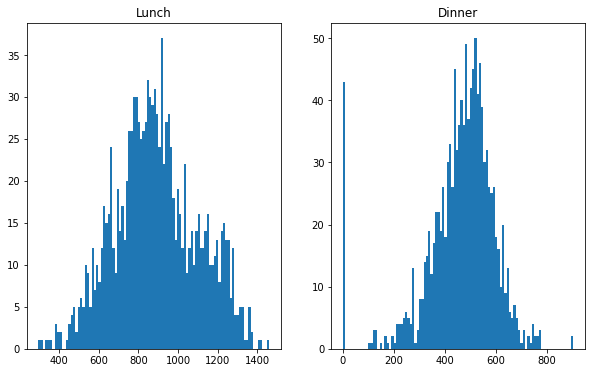

In [9]:
f, ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].hist(all_df['중식계'], bins=100)
ax[0].set_title('Lunch')
ax[1].hist(all_df['석식계'], bins=100)
ax[1].set_title('Dinner')
plt.show()

## 괄호 및 여러 특수문자 제거

In [10]:
def split_process(x):
    regex = '\*.*|\((.*?)\)|[+%><]|\&.*' 
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i or ':' in i or ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        elif ',' in i:
            x_.extend(i.split(','))
        elif '-' in i:
            x_.extend(i.split('-'))
        else:
            x_.append(re.sub(regex, '', i))
        
    x_ = list(set(x_)) # 가끔 중복되는 메뉴 제거(계란후라이가 두번 들어있는 식단도 있음)
    x_.remove('')
    return x_

breakfast_list = []
lunch_list = []
dinner_list = []

breakfast_list += all_df['조식메뉴'].apply(lambda x: split_process(x)).to_list()
lunch_list += all_df['중식메뉴'].apply(lambda x: split_process(x)).to_list()
dinner_list += all_df['석식메뉴'].apply(lambda x: split_process(x)).to_list()

In [11]:
print(all_df['조식메뉴'][0])
print(breakfast_list[0])
print(all_df['석식메뉴'][1])
print(dinner_list[1])

모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) 
['우유', '쌀밥', '두유', '쥐어채무침', '찐빵', '포기김치', '호두죽', '계란후라이', '주스', '모닝롤', '된장찌개']
콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국  유산슬 (쇠고기:호주산) 아삭고추무침  바나나  포기김치 (배추,고추가루:국내산) 
['콩나물밥', '어묵국', '포기김치', '유산슬', '바나나', '아삭고추무침']


## 시간대별 메뉴 리스트

In [12]:
def make_set(list):
    menu_set = set()
    for row in list:
        menu_set.update(row)
    return menu_set

breakfast_set = make_set(breakfast_list)
lunch_set = make_set(lunch_list)
dinner_set = make_set(dinner_list)

# 조중석식 메뉴 중복 제거 리스트
print(breakfast_set)
print(lunch_set)
print(dinner_set)

# 조중석식 메뉴 개수
print(len(breakfast_set), len(lunch_set), len(dinner_set))
# 겹치는 메뉴 개수
print(len(breakfast_set & lunch_set & dinner_set))

{'감자샌드', '브로컬리초장', '감자조림', '매운감자조림', '크림롤케익', '생크림단팥빵', '머위나물무침', '도라지생채', '삶은계란', '방풍나물', '감자고추장찌개', '마늘쫑메추리알장조림', '쇠고기미역국', '명엽채볶음', '케익', '후르츠산도', '크로와상', '어묵꽈리고추볶음', '브로콜리감자볶음', '얼갈이된장국', '우엉채조림', '오이맛살볶음', '홍게살죽', '꽃게탕', '사과롤케익', '곰피초장', '시금치나물무침', '오이도라지무침', '생크림와플', '오렌지케익빵', '콩가루배추국', '순두부계란국', '무생채', '피자토스트', '참나물생채', '오징어무국', '치즈케익', '양념김', '무청된장국', '옥수수스프', '시래기들깨탕', '건파래무침', '연근조림', '파래무침', '마약토스트', '열무된장나물', '전주식콩나물국해장국', '해물땡굴소스볶음', '검정콩조림', '두부김치국', '톳무침', '어묵토마토조림', '녹차호떡', '조각케익', '건새우아욱국', '동태탕', '맑은순두부국', '섭산적구이', '머핀', '피바지락국', '새알만두국', '김치도토리묵무침', '에그타르트', '호두죽', '브로컬리들깨소스', '시나몬페스츄리', '베이컨에그슬럿', '바지락무국', '토마토리코타치즈샐러드', '순두부백탕', '홍합살무국', '아귀지리탕', '크루통크림스프', '느타리팽이볶음', '아귀지리', '부추김무침', '김잔파무침', '파래김', '김치어묵국', '명엽채고추장볶음', '쑥갓무침', '건파래볶음', '커피콩빵', '치즈프레즐', '앙버터모닝빵', '건새우마늘쫑볶음', '꽈리고추멸치볶음', '야채호빵', '바지락살국', '감자스프', '열무나물', '소고기샤브국', '올갱이아욱국', '샌드위치', '쇠고기해장국', '사과베이비샐러드', '애호박새우젓볶음', '재래김', '차돌박이찌개', '초코핫케익', '소보로빵', '핫케이크', '크랜베리멸치볶음', '우엉간장조림', '팬케익', '김치콩나물국', '청포묵

## 자주 나오는 메뉴 제거

In [13]:
def tfidf_transform(list, set):
    word2id = defaultdict(lambda: 0) # 메뉴 이름 담을 딕셔너리
    list_contents = [] # 리스트로 저장된 식단을 코퍼스 단위로 바꿔 저장하는 리스트
    list_transformed = [] # tfidf 변환된 값을 저장하는 리스트
    emb = TfidfVectorizer(vocabulary=set, lowercase=False)
    for row in list:
        list_contents.append(' '.join(row)) # 코퍼스 단위로 변환
    emb_list = emb.fit_transform(list_contents) # tfidf 변환
    for idx, feature in enumerate(emb.get_feature_names()):
        word2id[feature] = idx # 딕셔너리에 메뉴 이름 저장
    for i, sent in enumerate(list_contents):
        list_transformed.append([(token, emb_list[i, word2id[token]])for token in sent.split()])

            
    return list_transformed

breakfast_tfidf = tfidf_transform(breakfast_list, breakfast_set)
lunch_tfidf = tfidf_transform(lunch_list, lunch_set)
dinner_tfidf = tfidf_transform(dinner_list, dinner_set)

In [14]:
THRESHOLD = 0.20 ### threshold보다 값이 작으면 제거
def delete_menu(THRESHOLD, list):
    useless = []
    for i, d in enumerate(list):
        for idx, m in enumerate(d):
            if m[1] < THRESHOLD:
                useless.append(m[0])
    return set(useless)
# 제거 대상
brkfst_del = list(delete_menu(THRESHOLD, breakfast_tfidf))
lunch_del = list(delete_menu(THRESHOLD, lunch_tfidf))
dinner_del = list(delete_menu(THRESHOLD, dinner_tfidf))
print(brkfst_del)
print(lunch_del)
print(dinner_del)


['흑미밥', '쌀밥', '우유', '와플&생크림', '스크램블에그', '모닝롤', '양상추샐러드', '누룽지탕', '포기김치', '계란후라이', '주스']
['귤', '흑미밥', '배추겉절이', '깻잎*쌈장', '양상추샐러드', '케일숙쌈*양념간장', '상추*쌈장', '잡곡밥', '케일*우렁쌈장', '쌀밥', '다시마쌈*씨앗쌈장', '와사비무쌈*쌈장', '양상추*쌈장', '그린샐러드*오렌지드레싱', '고추*쌈장', '생강채*쌈장', '찰현미밥', '쌈', '새송이*가지구이', '쑥갓쌈&쌈장', '버섯숙회*초장', '다시마*초장', '채소스틱&쌈장', '그린샐러드*키위D', '마늘*새우젓', '명이나물-장아찌', '청', '포기김치']
['귤', '흑미밥', '쌀밥', '＜자기', '날＞', '고추,양파', '배', '케일숙쌈*쌈장', '양파*쌈장', '파채*소스', '잡곡밥', '포기김치']


In [15]:
for i in [brkfst_del, lunch_del, dinner_del]:
    print(len(i))

11
28
12


In [16]:
dinner_list[204]

[]

In [17]:
for i in range(5):
    print(breakfast_list[i])

['우유', '쌀밥', '두유', '쥐어채무침', '찐빵', '포기김치', '호두죽', '계란후라이', '주스', '모닝롤', '된장찌개']
['시래기조림', '우유', '쌀밥', '팥죽', '두유', '단호박샌드', '포기김치', '호박젓국찌개', '계란후라이', '주스', '모닝롤']
['표고버섯죽', '베이글', '우유', '쌀밥', '두유', '느타리호박볶음', '포기김치', '계란후라이', '주스', '모닝롤', '콩나물국']
['우유', '쌀밥', '토마토샌드', '닭죽', '근대국', '두유', '멸치볶음', '포기김치', '계란후라이', '주스', '모닝롤']
['우유', '쇠고기죽', '쌀밥', '두유', '방풍나물', '와플', '재첩국', '포기김치', '계란후라이', '주스', '모닝롤']


In [18]:
del_col = [brkfst_del, lunch_del, dinner_del]
B = deepcopy(breakfast_list)
L = deepcopy(lunch_list)
D = deepcopy(dinner_list)
menu_list = [B, L, D]

def menu_processing(del_list, menu_list):
    list = []
    for d in del_list:
        for i in menu_list:
            if d in i:
                i.remove(d)

for i, j in zip(del_col,[B, L, D]):
    menu_processing(i, j)

B[0]

['두유', '쥐어채무침', '찐빵', '호두죽', '된장찌개']

### 제거후 데이터 프레임

In [19]:
for i in range(len(all_df)):
    all_df['조식메뉴'][i] = B[i]
    all_df['중식메뉴'][i] = L[i]
    all_df['석식메뉴'][i] = D[i]
all_df.rename(columns={'조식메뉴':'breakfast', '중식메뉴':'lunch', '석식메뉴':'dinner', '중식계':'lunch_y', '석식계':'dinner_y'}, inplace=True)

all_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,breakfast,lunch,dinner,lunch_y,dinner_y,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek
0,"[두유, 쥐어채무침, 찐빵, 호두죽, 된장찌개]","[요구르트, 쇠불고기, 청포묵무침, 계란찜, 오징어찌개]","[육개장, 두부조림, 자반고등어구이, 건파래무침]",1039.0,331.0,0.019223,0.057670,0.0,0.091503,0.923106,2016,2,1,5,0
1,"[시래기조림, 팥죽, 두유, 단호박샌드, 호박젓국찌개]","[요구르트, 모둠소세지구이, 마늘쫑무침, 김치찌개, 가자미튀김]","[콩나물밥, 어묵국, 유산슬, 바나나, 아삭고추무침]",867.0,560.0,0.019223,0.066513,0.0,0.122645,0.914264,2016,2,2,5,1
2,"[표고버섯죽, 베이글, 두유, 느타리호박볶음, 콩나물국]","[요구르트, 카레덮밥, 쫄면야채무침, 견과류조림, 팽이장국, 치킨핑거]","[청국장찌개, 새송이버섯볶음, 황태양념구이, 고기전]",1017.0,573.0,0.021530,0.069204,0.0,0.042676,0.909266,2016,2,3,5,2
3,"[토마토샌드, 닭죽, 근대국, 두유, 멸치볶음]","[쇠고기무국, 요구르트, 주꾸미볶음, 시금치나물, 부추전]","[우동, 군고구마, 미니김밥, 멕시칸샐러드, 무피클]",978.0,525.0,0.039985,0.084583,0.0,0.136486,0.875433,2016,2,4,5,3
4,"[쇠고기죽, 두유, 방풍나물, 와플, 재첩국]","[청경채무침, 요구르트, 우엉잡채, 돈육씨앗강정, 떡국]","[닭갈비, 감자소세지볶음, 콩나물무침, 차돌박이찌개]",925.0,330.0,0.106882,0.069589,0.0,0.013072,0.823529,2016,2,5,5,4
5,"[팬케익, 두유, 찐빵, 감자찌개, 명엽채무침, 견과류죽]","[요구르트, 시래기국, 쌈무, 양파절임, 도토리묵무침, 훈제오리구이]","[군만두, 락교, 맑은국, 과일샐러드, 참치회덮밥]",1045.0,550.0,0.147251,0.054979,0.0,0.160323,0.797770,2016,2,11,6,3
6,"[고구마죽, 야채샌드, 두유, 봄동된장국, 숙주나물]","[요구르트, 유채나물, 돈육굴소스볶음, 꽃게탕, 옥수수전]","[물파래무침, 깍두기, 미니함박, 김치콩나물국, 어묵볶음]",909.0,598.0,0.149558,0.059977,0.0,0.035755,0.790465,2016,2,12,6,4
7,"[치즈프레즐, 잣죽, 두유, 콩조림, 민물새우찌개]","[요구르트, 콩나물무침, 연두부, 닭감자조림, 시금치국]","[브로컬리초장, 임연수구이, 홍합미역국, 등갈비김치찜]",1268.0,672.0,0.033449,0.078431,0.0,0.185313,0.888120,2016,2,15,7,0
8,"[어묵국, 단호박죽, 두유, 김구이, 마늘빵]","[쇠고기무국, 요구르트, 탕수어, 오징어숙회무침, 취나물]","[쇠불고기, 해파리겨자채, 된장찌개, 봄동무침]",1014.0,523.0,0.027682,0.090734,0.0,0.202230,0.881584,2016,2,16,7,1
9,"[흑임자죽, 북어계란국, 무생채, 두유, 참치샌드]","[요구르트, 냉이된장국, 치커리무침, 통도라지구이, 쇠고기장조림]","[요플레, 맑은국, 새우또띠아, 쨔샤이무침, 볶음밥]",916.0,588.0,0.029988,0.096117,0.0,0.008843,0.873895,2016,2,17,7,2


In [20]:
type(all_df['breakfast'][0])

list

In [21]:
all_df.shape

(1255, 15)

In [22]:
da = []
for i in all_df['lunch']:
    for menu in i:
        da.append(menu)
print(da)
print(len(set(da)))

['요구르트', '쇠불고기', '청포묵무침', '계란찜', '오징어찌개', '요구르트', '모둠소세지구이', '마늘쫑무침', '김치찌개', '가자미튀김', '요구르트', '카레덮밥', '쫄면야채무침', '견과류조림', '팽이장국', '치킨핑거', '쇠고기무국', '요구르트', '주꾸미볶음', '시금치나물', '부추전', '청경채무침', '요구르트', '우엉잡채', '돈육씨앗강정', '떡국', '요구르트', '시래기국', '쌈무', '양파절임', '도토리묵무침', '훈제오리구이', '요구르트', '유채나물', '돈육굴소스볶음', '꽃게탕', '옥수수전', '요구르트', '콩나물무침', '연두부', '닭감자조림', '시금치국', '쇠고기무국', '요구르트', '탕수어', '오징어숙회무침', '취나물', '요구르트', '냉이된장국', '치커리무침', '통도라지구이', '쇠고기장조림', '요구르트', '유부장국', '낙지비빔밥', '고구마치즈구이', '해초무침', '요구르트', '치킨무', '새송이버섯볶음', '마늘간장치킨', '대구찌개', '돌나물무침', '요구르트', '파래김', '쇠고기느타리국', '호박꼬지', '갈치구이', '오곡밥', '부럼', '요구르트', '버섯잡채', '꽃상추무침', '돈육간장볶음', '콩나물국', '요구르트', '맛탕', '소세지피망볶음', '비빔밥', '팽이장국', '닭갈비', '곰피초장', '요구르트', '새싹두부구이', '북어계란국', '요구르트', '오징어볶음', '수제비국', '계란찜', '도라지초무침', '치커리생채', '요구르트', '제육볶음', '얼갈이된장국', '늙은호박전', '맛살계란말이', '주꾸미볶음', '쇠고기미역국', '아삭고추무침', '탕수육', '근대된장국', '요구르트', '무생채', '새송이버섯조림', '깍두기', '열무된장나물', '메추리알조림', '부대찌개', '가자미튀김', '닭갈비', '모둠묵', '톳두부무침', '콩나물국', '깍두기', '소세지구이', '풋마늘초무침', '고등어김치말이', '차

In [23]:
def menu_making(col):
    array = []
    for i in col:
        for j in i:
            array.append(j)
    return list(set(array))

breakfast_s = menu_making(all_df['breakfast'])
lunch_s = menu_making(all_df['lunch'])
dinner_s = menu_making(all_df['dinner'])
# print(breakfast_list[:10])
# print(lunch_list[:10])
# print(dinner_list[:10])
# print(len(breakfast_list), len(lunch_list), len(dinner_list))


In [24]:
print(len(breakfast_s), len(lunch_s), len(dinner_s))

794 1562 1568


In [25]:
all_df['lunch'][0]

['요구르트', '쇠불고기', '청포묵무침', '계란찜', '오징어찌개']

In [26]:
all_df['dinner'][0]

['육개장', '두부조림', '자반고등어구이', '건파래무침']

In [27]:
train_df = all_df[:len(train_df)]
test_df = all_df[len(train_df):]
print(train_df.shape, test_df.shape)

(1205, 15) (50, 15)


#

## OneHot Encoding

In [86]:
from sklearn.decomposition import SparsePCA

In [87]:
lunch_oh = pd.DataFrame(np.zeros([len(all_df), len(lunch_s)]), columns=lunch_s)
dinner_oh = pd.DataFrame(np.zeros([len(all_df), len(dinner_s)]), columns=dinner_s)

In [88]:
for i in range(len(all_df['lunch'])):
    for m in all_df['lunch'][i]:
        lunch_oh.loc[i, m] = 1

lunch_oh.loc[0, all_df['lunch'][0]] 

청포묵무침    1.0
오징어찌개    1.0
계란찜      1.0
요구르트     1.0
쇠불고기     1.0
Name: 0, dtype: float64

In [89]:
for i in range(len(all_df['dinner'])):
    for m in all_df['dinner'][i]:
        dinner_oh.loc[i, m] = 1

dinner_oh.loc[0, all_df['dinner'][0]] 

육개장        1.0
건파래무침      1.0
자반고등어구이    1.0
두부조림       1.0
Name: 0, dtype: float64

In [90]:
dinner_oh

,우거지국,온두부,참나물겉절이,참치마요덮밥,비프스파게티,로제스파게티,모둠묵,미니버거,미더덕콩나물찜,비엔나볶음,너비아니,미니국수,비름나물,낙지젓무침,요플레,돈까스,돌나물,류산슬,시래기삼치조림,허니슈스트링감자,미니우동,후르츠탕수육,고등어김치찜,아오리사과,채소튀김,김가루잔파무침,절인고추,들깨버섯국,숯불양념꼬지어묵,바지락살국,장국,김치국,고추지무침,감자소세지볶음,치커리유자청무침,오이초무침,충무김밥,비빔야채만두,떡갈비주먹밥,오이양파무침,...,건도토리묵파프리카볶음,명엽채볶음,비엔나채소볶음,갓김치,어묵잡채볶음,볶음밥,동파육,언양식바싹불고기,연근조림,김치고기전,찐만두,녹두전,오징어순대볶음,맛살전,김계란말이,차돌비빔국수,배추된장국,부추생채,크래미오이보트샐러드,꼬치어묵탕,청양멸치주먹밥,황태해장국,치킨핑거,참나물생채,섭산적고추장구이,진미채무말랭이무침,해라피겨자채,제육춘장볶음,수제보쌈김치,고추잡채,김말이튀김,떡볶이,잔치국수,우엉잡채,미역국,고등어자반찜,도라지오이초무침,해물파전,꽁치김치찜,삼겹살구이
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
print(lunch_oh.shape, dinner_oh.shape)

(1255, 1562) (1255, 1568)


In [92]:
transformer = SparsePCA(n_components=10, random_state=0)
transformer.fit(lunch_oh)
lunch_pca = transformer.transform(lunch_oh)

transformer = SparsePCA(n_components=10, random_state=0)
transformer.fit(dinner_oh)
dinner_pca = transformer.transform(dinner_oh)

print(lunch_pca.shape, dinner_pca.shape)

KeyboardInterrupt: ignored

In [ ]:
all_df.drop(['breakfast', 'lunch', 'dinner'], axis=1, inplace=True)

all_df.head()

In [ ]:
print(all_df.shape)

In [ ]:
lunch_oh_df = pd.concat([all_df, lunch_oh], axis=1)
dinner_oh_df = pd.concat([all_df, dinner_oh], axis=1)
print(lunch_oh_df.shape, dinner_oh_df.shape)

In [ ]:
lunch_oh_df.head()

In [ ]:
dinner_oh_df.head()

### train test split

In [ ]:
l_oh_train_df = lunch_oh_df[:len(train_df)]
l_oh_test_df = lunch_oh_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)
d_oh_train_df = dinner_oh_df[:len(train_df)]
d_oh_test_df = dinner_oh_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)

print(l_oh_train_df.shape, l_oh_test_df.shape)
print(d_oh_train_df.shape, d_oh_test_df.shape)

In [ ]:
lunch_X = l_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
lunch_y = l_oh_train_df['lunch_y']
dinner_X = d_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
dinner_y = d_oh_train_df['dinner_y']
for col in (lunch_X, lunch_y, dinner_X, dinner_y):
    print(col.head(1))
# 점심
l_X_train, l_X_test, l_y_train, l_y_test = train_test_split(lunch_X, lunch_y, test_size=0.2, random_state=2021)
# 저녁
d_X_train, d_X_test, d_y_train, d_y_test = train_test_split(dinner_X, dinner_y, test_size=0.2, random_state=2021)

col1 = [l_X_train, l_X_test, l_y_train, l_y_test]
col2 = [d_X_train, d_X_test, d_y_train, d_y_test]
for i, j in zip(col1, col2):
    print('\nlunch',i.shape)
    print('dinner',j.shape)

### LightGBM

In [ ]:
from optuna.samplers import TPESampler
sampler = TPESampler(seed=10)
def objective(trial):

    param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 14),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

    lgbm_regr = lgb.LGBMRegressor(**param)
    lgbm = lgbm_regr.fit(l_X_train, l_y_train , eval_set = [(l_X_train, l_y_train)], verbose=False)
    mae = mean_absolute_error(l_y_test, lgbm.predict(l_X_test))
    return mae
        
l_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
l_study_lgb.optimize(objective, n_trials=50)

In [ ]:
sampler = TPESampler(seed=10)
def objective(trial):

    param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

    lgbm_regr = lgb.LGBMRegressor(**param)
    lgbm = lgbm_regr.fit(d_X_train, d_y_train , eval_set = [(d_X_train, d_y_train)], verbose=False)
    mae = mean_absolute_error(d_y_test, lgbm.predict(d_X_test))
    return mae
        
d_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
d_study_lgb.optimize(objective, n_trials=50)

In [ ]:
print('Lunch Best Trial: score {},\nparams {}'.format(l_study_lgb.best_trial.value, l_study_lgb.best_trial.params))
print('Dinner Best Trial: score {},\nparams {}'.format(d_study_lgb.best_trial.value, d_study_lgb.best_trial.params))

In [ ]:
l_trial_lgb = l_study_lgb.best_trial
lunch_lgb_params = l_trial_lgb.params
print(lunch_lgb_params)
d_trial_lgb = d_study_lgb.best_trial
dinner_lgb_params = d_trial_lgb.params
print(dinner_lgb_params)

#### Predict

In [ ]:
lunch_lgb_model = lgb.LGBMRegressor(**lunch_lgb_params)
lunch_lgb_model.fit(l_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1), l_oh_train_df['lunch_y'], eval_metric='mae')
lunch_lgb_pred = lunch_lgb_model.predict(l_oh_test_df)

In [ ]:
dinner_lgb_model = lgb.LGBMRegressor(**dinner_lgb_params)
dinner_lgb_model.fit(d_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1), d_oh_train_df['dinner_y'], eval_metric='mae')
dinner_lgb_pred = dinner_lgb_model.predict(d_oh_test_df)

In [ ]:
print(lunch_lgb_pred)
print(dinner_lgb_pred)

In [ ]:
lgb_submit = pd.read_csv(PATH + 'sample_submission.csv')
lgb_submit['중식계'] = lunch_lgb_pred
lgb_submit['석식계'] = dinner_lgb_pred
lgb_submit.to_csv(PATH + 'lgb_pca30.csv', index=False)
lgb_submit.head()

### MLP

In [ ]:
#trainset과 testset 분리
l_oh_train_df = lunch_oh_df[:len(train_df)]
l_oh_test_df = lunch_oh_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)
d_oh_train_df = dinner_oh_df[:len(train_df)]
d_oh_test_df = dinner_oh_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)

print(l_oh_train_df.shape, l_oh_test_df.shape)
print(d_oh_train_df.shape, d_oh_test_df.shape)

In [ ]:
#정규화
l_oh_train_df['lunch_y'] = StandardScaler().fit_transform(l_oh_train_df['lunch_y'].values.reshape(-1, 1))
d_oh_train_df['dinner_y'] = StandardScaler().fit_transform(d_oh_train_df['dinner_y'].values.reshape(-1, 1))
l_oh_train_df['year'] = LabelEncoder().fit_transform(l_oh_train_df['year'].values.reshape(-1, 1))
l_oh_test_df['year'] = LabelEncoder().fit_transform(l_oh_test_df['year'].values.reshape(-1, 1))
d_oh_train_df['year'] = LabelEncoder().fit_transform(d_oh_train_df['year'].values.reshape(-1, 1))
d_oh_test_df['year'] = LabelEncoder().fit_transform(d_oh_test_df['year'].values.reshape(-1, 1))

In [ ]:
lunch_X = l_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
lunch_y = l_oh_train_df['lunch_y']
dinner_X = d_oh_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
dinner_y = d_oh_train_df['dinner_y']

# 점심
l_X_train, l_X_test, l_y_train, l_y_test = train_test_split(lunch_X, lunch_y, test_size=0.2, random_state=2021)
# 저녁
d_X_train, d_X_test, d_y_train, d_y_test = train_test_split(dinner_X, dinner_y, test_size=0.2, random_state=2021)
print(l_X_train.shape,l_y_train.shape)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  l_X_train, l_y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
model.summary()

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(l_X_train, l_y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


In [ ]:
lunch_pred=model.predict(l_X_test)
lunch_pred

In [ ]:
lunch_pred_e = np.std(all_df['lunch_y'][:1205]) * lunch_pred + np.mean(all_df['lunch_y'][:1205])
lunch_pred_e

In [ ]:
l_y_test=np.std(all_df['lunch_y'][:1205])*l_y_test+np.mean(all_df['lunch_y'][:1205])
l_y_test

In [ ]:
print(mean_absolute_error(l_y_test,lunch_pred_e))

In [ ]:
lunch_sub=model.predict(l_oh_test_df)

In [ ]:
lunch_sub_e = np.std(all_df['lunch_y'][:1205]) * lunch_sub + np.mean(all_df['lunch_y'][:1205])
lunch_sub_e

In [ ]:
#모델생성
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(dinner_X.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  d_X_train, d_y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(d_X_train, d_y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

In [ ]:
dinner_pred=model.predict(d_X_test)
dinner_pred

In [ ]:
dinner_pred_e = np.std(all_df['dinner_y'][:1205]) * dinner_pred + np.mean(all_df['dinner_y'][:1205])
dinner_pred_e

In [ ]:
d_y_test = np.std(all_df['dinner_y'][:1205]) * d_y_test + np.mean(all_df['dinner_y'][:1205])
d_y_test

In [ ]:
dinner_sub_e=np.std(all_df['dinner_y'][:1205]) * dinner_sub + np.mean(all_df['dinner_y'][:1205])
dinner_sub_e

In [ ]:
# write submission
DL_submit = pd.read_csv(PATH + 'sample_submission.csv')
DL_submit['중식계'] = lunch_sub_e
DL_submit['석식계'] = dinner_sub_e
DL_submit.to_csv(PATH + 'DL_base.csv', index=False)
DL_submit.head()

## FastText

In [28]:
# HYPER PARAMETERS

class CFG:
    emb_dim = 500

args = CFG

In [29]:
def food_combinations(train=True):
    col = ['breakfast', 'lunch', 'dinner']
    array = []
    if train:
        for c in col:
            for l in all_df[:len(train_df)][c]:
                array.append(l)
    else:
        for c in col:
            for l in all_df[len(train_df):][c]:
                array.append(l)
    print(len(array))
    print(array[:3])
    return array

In [30]:
TRAIN_W2V = True

try:
    model = FastText.load(PATH + 'food_embedding.model')
    print("Model loaded")
    if not TRAIN_W2V:
        print('Training test set using current model')
        test_food = food_combinations(train=False)
        model.train(test_food, total_examples=len(test_food))

except:
    if TRAIN_W2V:
        print("Training w2v")
        train_food = food_combinations(train=True)
        model = FastText(
            sentences=train_food, 
            vector_size=args.emb_dim, # 벡터 사이즈
            window=30,
            workers=-1,
            sg=1, # 0: CBOW, 1: skip-gram
            epochs=5000
                         )
        model.save(PATH + 'food_embedding.model')
    else:
        print("Load Model. Do not train.")
        

Model loaded


In [96]:
model.wv.most_similar('롤케익')

[('메론롤케익', 0.2387872338294983),
 ('핫케익', 0.19615353643894196),
 ('팬케익', 0.16169056296348572),
 ('초코핫케익', 0.15142035484313965),
 ('크림스프', 0.14002297818660736),
 ('버섯잡채', 0.1309124380350113),
 ('우엉조림', 0.12402337789535522),
 ('오이도라지무침', 0.12099647521972656),
 ('돈육잡채', 0.11367535591125488),
 ('옛날돈까스', 0.11342933028936386)]

In [97]:
model.wv.most_similar('돼지갈비찜')

[('매운돼지갈비찜', 0.5322608947753906),
 ('올챙이만두국', 0.15996651351451874),
 ('얼갈이된장국', 0.13743513822555542),
 ('새송이죽', 0.13469423353672028),
 ('만두국', 0.13191868364810944),
 ('미소장국', 0.12965227663516998),
 ('미역줄기볶음', 0.1141514703631401),
 ('감자양파국', 0.11404674500226974),
 ('알타리김치', 0.1116693913936615),
 ('낙지볶음', 0.11138071119785309)]

In [ ]:
model.wv.get_vector('쥐어채무침')

array([ 1.45557104e-04, -7.51849788e-04,  3.73546209e-04, -1.64353885e-04,
       -1.85506666e-04, -3.40138540e-05,  1.26731815e-04, -4.77848575e-04,
        2.34446234e-05,  1.23516656e-04,  4.93232103e-04, -3.80756072e-04,
        5.31954574e-04,  3.23976565e-05, -2.46468757e-04, -3.67124245e-04,
        1.37738258e-04, -1.71999229e-04,  2.53007838e-05, -1.36086412e-04,
        3.71910864e-05,  1.31366818e-04, -1.64176919e-04, -4.08290100e-04,
        2.66224291e-04, -2.81337008e-04,  1.35904455e-04,  3.09457449e-04,
        4.96791035e-04, -1.18220807e-04,  4.33393907e-05,  7.40717514e-05,
        4.08225926e-04,  3.40744184e-04,  3.91921290e-04, -6.15296769e-04,
        5.62850910e-04,  1.57421760e-04, -6.50940128e-05,  1.22355152e-04,
       -1.84530727e-04, -7.23127887e-05,  5.71310629e-05,  4.74386296e-04,
        1.47279963e-04,  2.19473382e-04,  2.95773178e-04, -1.18978205e-04,
       -7.20013777e-05, -2.30731006e-04, -4.65098419e-05, -6.74531184e-05,
       -3.35399527e-04, -

In [31]:
train_df = all_df[:len(train_df)]
print(train_df.shape)

(1205, 15)


In [32]:
def food_embedding(menu_row):
    vec_ = np.zeros(args.emb_dim)
    for i in menu_row:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(menu_row)
    return vec_

In [33]:
train_df['breakfast_embedding'] = train_df['breakfast'].apply(lambda x: food_embedding(x))
train_df['lunch_embedding'] = train_df['lunch'].apply(lambda x: food_embedding(x))
train_df['dinner_embedding'] = train_df['dinner'].apply(lambda x: food_embedding(x))
y_lunch = train_df['lunch_y']
y_dinner = train_df['dinner_y']

train_df.drop(['breakfast', 'lunch', 'dinner', 'lunch_y', 'dinner_y'], axis=1, inplace=True)
X_common = train_df.iloc[:, :10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

#### Fill nan

In [34]:
for i in range(len(train_df)):
    if np.isnan(train_df['dinner_embedding'][i]).sum() != 0:
        print(i,':', np.isnan(train_df['dinner_embedding'][i]).sum())
        np.nan_to_num(train_df['dinner_embedding'][i], copy=False, nan=0.0)

204 : 500
224 : 500
244 : 500
262 : 500
281 : 500
306 : 500
346 : 500
392 : 500
412 : 500
424 : 500
449 : 500
468 : 500
492 : 500
510 : 500
529 : 500
549 : 500
571 : 500
586 : 500
589 : 500
609 : 500
633 : 500
648 : 500
687 : 500
872 : 500
890 : 500
912 : 500
932 : 500
955 : 500


In [35]:
np.isnan(train_df['dinner_embedding'][i]).sum()

0

In [103]:
train_df.head(3)

,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek,breakfast_embedding,lunch_embedding,dinner_embedding
0,0.019223,0.057670,0.0,0.091503,0.923106,2016,2,1,5,0,"[6.532135012093932e-06, 3.563666541595012e-05,...","[0.00011001809034496545, 0.0001505380787421018...","[2.6348612664151005e-05, 0.0001585289625154473..."
1,0.019223,0.066513,0.0,0.122645,0.914264,2016,2,2,5,1,"[9.996268490795047e-05, 1.1014865594916046e-05...","[9.597888783900999e-05, 2.8851501701865347e-05...","[-0.0002805278236337472, -0.000220696203905390..."
2,0.021530,0.069204,0.0,0.042676,0.909266,2016,2,3,5,2,"[8.358935374417343e-05, 0.00014487731968984007...","[4.817684839508729e-05, 0.00011808696035586763...","[-0.0003161334670949145, -7.0811178147778264e-..."


In [36]:
emb_arr_lunch = np.array(train_df['lunch_embedding'].to_numpy().tolist())
emb_arr_dinner = np.array(train_df['dinner_embedding'].to_numpy().tolist())

X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

In [105]:
train_df['lunch_embedding'][0][-1]

8.843973191687837e-05

In [106]:
X_train_lunch

array([[ 1.92233756e-02,  5.76701269e-02,  0.00000000e+00, ...,
         1.42352910e-04, -1.39753064e-04,  8.84397319e-05],
       [ 1.92233756e-02,  6.65128797e-02,  0.00000000e+00, ...,
        -2.02547933e-05, -2.18011146e-05, -1.03104157e-04],
       [ 2.15301807e-02,  6.92041522e-02,  0.00000000e+00, ...,
        -3.64747272e-05, -5.40556211e-05,  5.69504112e-05],
       ...,
       [ 8.54844117e-02,  8.31377808e-02,  1.01575595e-01, ...,
        -6.90102894e-05, -1.90945753e-05, -1.90992805e-04],
       [ 3.58699296e-02,  5.12906470e-02,  1.09621187e-01, ...,
        -1.65204966e-04,  6.27871777e-05,  2.63965631e-04],
       [ 2.31310761e-02,  6.13476366e-02,  1.21354341e-01, ...,
         2.28817392e-05,  8.53871448e-05, -5.36602965e-05]])

### train-test-split

In [37]:
X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch,
                                                                            y_lunch,
                                                                            test_size=0.2,
                                                                            random_state=42)
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner,
                                                                                y_dinner,
                                                                                test_size=0.2,
                                                                                random_state=42)


In [38]:
# Simple LGBM Regressor w/o tuning
model_lunch = LGBMRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = LGBMRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))

lunch mae:  83.43456259137002
dinner mae:  54.64887010569683


### LightGBM

In [116]:
# !apt-get -qq install --no-install-recommends nvidia-375
# !apt-get -qq install --no-install-recommends nvidia-opencl-icd-375 nvidia-opencl-dev opencl-headers
# !apt-get -qq install --no-install-recommends git cmake build-essential libboost-dev libboost-system-dev libboost-filesystem-dev
# !pip3 install -qq lightgbm --install-option=--gpu


/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [39]:
# 점심
from optuna.samplers import TPESampler 
sampler = TPESampler(seed=10)
def objective(trial):

    param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'device': 'gpu',
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

    lgbm_regr = lgb.LGBMRegressor(**param)
    lgbm = lgbm_regr.fit(X_train_lunch, y_train_lunch , eval_set = [(X_test_lunch, y_test_lunch)], verbose=False)
    mae = mean_absolute_error(y_test_lunch, lgbm.predict(X_test_lunch))
    return mae
        
l_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
l_study_lgb.optimize(objective, n_trials=50)

[I 2021-07-13 08:19:21,744] A new study created in memory with name: no-name-9b8c144c-c638-469a-aea8-c75044085d17
[W 2021-07-13 08:19:21,798] Trial 0 failed because of the following error: LightGBMError('GPU Tree Learner was not enabled in this build.\nPlease recompile with CMake option -DUSE_GPU=1')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 216, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-39-50ef81c51035>", line 25, in objective
    lgbm = lgbm_regr.fit(X_train_lunch, y_train_lunch , eval_set = [(X_test_lunch, y_test_lunch)], verbose=False)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 685, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=tr

LightGBMError: ignored

In [ ]:
sampler = TPESampler(seed=10)
def objective(trial):

    param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'device': 'gpu',
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

    lgbm_regr = lgb.LGBMRegressor(**param)
    lgbm = lgbm_regr.fit(X_train_dinner, y_train_dinner , eval_set = [(X_test_dinner, y_test_dinner)], verbose=False)
    mae = mean_absolute_error(y_test_dinner, lgbm.predict(X_test_dinner))
    return mae
        
d_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
d_study_lgb.optimize(objective, n_trials=50)

[I 2021-07-05 16:23:02,091] A new study created in memory with name: no-name-2ceacf6b-7207-47a7-9fd3-91d20790ea2a


[LightGBM] [Warning] feature_fraction is set=0.5348779873185086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5348779873185086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4656004675652718e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4656004675652718e-08
[LightGBM] [Warning] bagging_fraction is set=0.5188377188557745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5188377188557745
[LightGBM] [Warning] lambda_l1 is set=0.014810344004555135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014810344004555135


[I 2021-07-05 16:23:44,086] Trial 0 finished with value: 97.37904480864037 and parameters: {'lambda_l1': 0.014810344004555135, 'lambda_l2': 1.4656004675652718e-08, 'num_leaves': 254, 'max_depth': 8, 'n_estimators': 2844, 'feature_fraction': 0.5348779873185086, 'bagging_fraction': 0.5188377188557745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 97.37904480864037.


[LightGBM] [Warning] feature_fraction is set=0.8875725769912681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875725769912681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.003040034742832493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003040034742832493
[LightGBM] [Warning] bagging_fraction is set=0.7675156400976328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675156400976328
[LightGBM] [Warning] lambda_l1 is set=5.090008568091192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.090008568091192e-08


[I 2021-07-05 16:24:02,173] Trial 1 finished with value: 47.76887888236263 and parameters: {'lambda_l1': 5.090008568091192e-08, 'lambda_l2': 0.003040034742832493, 'num_leaves': 382, 'max_depth': 3, 'n_estimators': 2902, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.8044801690398071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044801690398071
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.005207224083783965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005207224083783965
[LightGBM] [Warning] bagging_fraction is set=0.6650999046537976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650999046537976
[LightGBM] [Warning] lambda_l1 is set=0.21988367156694333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21988367156694333


[I 2021-07-05 16:24:13,430] Trial 2 finished with value: 50.92175652694735 and parameters: {'lambda_l1': 0.21988367156694333, 'lambda_l2': 0.005207224083783965, 'num_leaves': 218, 'max_depth': 3, 'n_estimators': 2305, 'feature_fraction': 0.8044801690398071, 'bagging_fraction': 0.6650999046537976, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.945189328485201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945189328485201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0015965313667163816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015965313667163816
[LightGBM] [Warning] bagging_fraction is set=0.5915416533931271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915416533931271
[LightGBM] [Warning] lambda_l1 is set=0.00012738137732610437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012738137732610437


[I 2021-07-05 16:25:00,316] Trial 3 finished with value: 49.955411271789416 and parameters: {'lambda_l1': 0.00012738137732610437, 'lambda_l2': 0.0015965313667163816, 'num_leaves': 241, 'max_depth': 8, 'n_estimators': 2943, 'feature_fraction': 0.945189328485201, 'bagging_fraction': 0.5915416533931271, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.8915721974020412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8915721974020412
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.042604022999246406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042604022999246406
[LightGBM] [Warning] bagging_fraction is set=0.5193685238072874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5193685238072874
[LightGBM] [Warning] lambda_l1 is set=8.163471763379958e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.163471763379958e-08


[I 2021-07-05 16:25:35,973] Trial 4 finished with value: 56.59483209001847 and parameters: {'lambda_l1': 8.163471763379958e-08, 'lambda_l2': 0.042604022999246406, 'num_leaves': 20, 'max_depth': 7, 'n_estimators': 3055, 'feature_fraction': 0.8915721974020412, 'bagging_fraction': 0.5193685238072874, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.6355175463679523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6355175463679523
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3318126555538504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3318126555538504e-06
[LightGBM] [Warning] bagging_fraction is set=0.4560762247351902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560762247351902
[LightGBM] [Warning] lambda_l1 is set=0.010893853540963833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010893853540963833


[I 2021-07-05 16:25:51,148] Trial 5 finished with value: 97.2302411208719 and parameters: {'lambda_l1': 0.010893853540963833, 'lambda_l2': 2.3318126555538504e-06, 'num_leaves': 354, 'max_depth': 5, 'n_estimators': 1409, 'feature_fraction': 0.6355175463679523, 'bagging_fraction': 0.4560762247351902, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.5508244805242356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508244805242356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3581671060741645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3581671060741645
[LightGBM] [Warning] bagging_fraction is set=0.7584229889385306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584229889385306
[LightGBM] [Warning] lambda_l1 is set=1.1828116394242723e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1828116394242723e-05


[I 2021-07-05 16:26:24,813] Trial 6 finished with value: 65.46295591306502 and parameters: {'lambda_l1': 1.1828116394242723e-05, 'lambda_l2': 0.3581671060741645, 'num_leaves': 396, 'max_depth': 6, 'n_estimators': 4253, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.5984315871892792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984315871892792
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0618360930258403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0618360930258403e-08
[LightGBM] [Warning] bagging_fraction is set=0.8642981777263575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642981777263575
[LightGBM] [Warning] lambda_l1 is set=0.0005267577135346555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005267577135346555


[I 2021-07-05 16:26:34,924] Trial 7 finished with value: 97.37929450899564 and parameters: {'lambda_l1': 0.0005267577135346555, 'lambda_l2': 2.0618360930258403e-08, 'num_leaves': 144, 'max_depth': 3, 'n_estimators': 2013, 'feature_fraction': 0.5984315871892792, 'bagging_fraction': 0.8642981777263575, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.8579443522862087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8579443522862087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0012357458041729475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012357458041729475
[LightGBM] [Warning] bagging_fraction is set=0.926857985634915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926857985634915
[LightGBM] [Warning] lambda_l1 is set=3.3068536483753737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3068536483753737e-06


[I 2021-07-05 16:26:59,180] Trial 8 finished with value: 52.89899697450681 and parameters: {'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.5818375363906209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818375363906209
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006063078395671604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006063078395671604
[LightGBM] [Warning] bagging_fraction is set=0.5452455252421164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5452455252421164
[LightGBM] [Warning] lambda_l1 is set=0.0001281542517497079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001281542517497079


[I 2021-07-05 16:27:04,294] Trial 9 finished with value: 83.51147514159052 and parameters: {'lambda_l1': 0.0001281542517497079, 'lambda_l2': 0.0006063078395671604, 'num_leaves': 106, 'max_depth': 5, 'n_estimators': 809, 'feature_fraction': 0.5818375363906209, 'bagging_fraction': 0.5452455252421164, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7649442484108072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649442484108072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.010479332494921e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.010479332494921e-06
[LightGBM] [Warning] bagging_fraction is set=0.7880669612015251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7880669612015251
[LightGBM] [Warning] lambda_l1 is set=1.6785873892849563e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6785873892849563e-08


[I 2021-07-05 16:27:27,940] Trial 10 finished with value: 96.94951796164791 and parameters: {'lambda_l1': 1.6785873892849563e-08, 'lambda_l2': 3.010479332494921e-06, 'num_leaves': 341, 'max_depth': 4, 'n_estimators': 3558, 'feature_fraction': 0.7649442484108072, 'bagging_fraction': 0.7880669612015251, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.9991122238129395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991122238129395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.61939793719469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.61939793719469e-05
[LightGBM] [Warning] bagging_fraction is set=0.6585514682875593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585514682875593
[LightGBM] [Warning] lambda_l1 is set=8.9826258759353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.9826258759353e-07


[I 2021-07-05 16:31:47,680] Trial 11 finished with value: 91.93572631454262 and parameters: {'lambda_l1': 8.9826258759353e-07, 'lambda_l2': 2.61939793719469e-05, 'num_leaves': 287, 'max_depth': 9, 'n_estimators': 3632, 'feature_fraction': 0.9991122238129395, 'bagging_fraction': 0.6585514682875593, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.9922869658927289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922869658927289
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.030766178350701442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030766178350701442
[LightGBM] [Warning] bagging_fraction is set=0.6307116556352568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6307116556352568
[LightGBM] [Warning] lambda_l1 is set=0.0010032552297938406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010032552297938406


[I 2021-07-05 16:32:32,735] Trial 12 finished with value: 50.167622567307276 and parameters: {'lambda_l1': 0.0010032552297938406, 'lambda_l2': 0.030766178350701442, 'num_leaves': 311, 'max_depth': 9, 'n_estimators': 2453, 'feature_fraction': 0.9922869658927289, 'bagging_fraction': 0.6307116556352568, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.41844661211798795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41844661211798795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00015468424548794194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015468424548794194
[LightGBM] [Warning] bagging_fraction is set=0.995679260563783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995679260563783
[LightGBM] [Warning] lambda_l1 is set=1.9886276185414409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9886276185414409e-07


[I 2021-07-05 16:34:03,229] Trial 13 finished with value: 77.61066725336029 and parameters: {'lambda_l1': 1.9886276185414409e-07, 'lambda_l2': 0.00015468424548794194, 'num_leaves': 387, 'max_depth': 7, 'n_estimators': 3556, 'feature_fraction': 0.41844661211798795, 'bagging_fraction': 0.995679260563783, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.9290019894565231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9290019894565231
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9773722751809201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9773722751809201
[LightGBM] [Warning] bagging_fraction is set=0.750295356922126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750295356922126
[LightGBM] [Warning] lambda_l1 is set=2.8821931552561775e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8821931552561775e-05


[I 2021-07-05 16:34:39,653] Trial 14 finished with value: 76.56558180227766 and parameters: {'lambda_l1': 2.8821931552561775e-05, 'lambda_l2': 0.9773722751809201, 'num_leaves': 219, 'max_depth': 8, 'n_estimators': 1756, 'feature_fraction': 0.9290019894565231, 'bagging_fraction': 0.750295356922126, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7285367937084144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7285367937084144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.013133026541985783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013133026541985783
[LightGBM] [Warning] bagging_fraction is set=0.5989394570002292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5989394570002292
[LightGBM] [Warning] lambda_l1 is set=1.0885522537644062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0885522537644062e-08


[I 2021-07-05 16:35:09,963] Trial 15 finished with value: 53.95428675645124 and parameters: {'lambda_l1': 1.0885522537644062e-08, 'lambda_l2': 0.013133026541985783, 'num_leaves': 28, 'max_depth': 7, 'n_estimators': 3001, 'feature_fraction': 0.7285367937084144, 'bagging_fraction': 0.5989394570002292, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.9592124084612702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592124084612702
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4319355308173353e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4319355308173353e-05
[LightGBM] [Warning] bagging_fraction is set=0.4072835615446248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072835615446248
[LightGBM] [Warning] lambda_l1 is set=0.006757265265334436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006757265265334436


[I 2021-07-05 16:35:20,816] Trial 16 finished with value: 94.3544823931873 and parameters: {'lambda_l1': 0.006757265265334436, 'lambda_l2': 3.4319355308173353e-05, 'num_leaves': 266, 'max_depth': 8, 'n_estimators': 2583, 'feature_fraction': 0.9592124084612702, 'bagging_fraction': 0.4072835615446248, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.8133108831404763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133108831404763
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.19063245323117958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19063245323117958
[LightGBM] [Warning] bagging_fraction is set=0.8359226382813782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359226382813782
[LightGBM] [Warning] lambda_l1 is set=0.4749952337893574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4749952337893574


[I 2021-07-05 16:35:47,115] Trial 17 finished with value: 49.719587109631284 and parameters: {'lambda_l1': 0.4749952337893574, 'lambda_l2': 0.19063245323117958, 'num_leaves': 163, 'max_depth': 5, 'n_estimators': 3778, 'feature_fraction': 0.8133108831404763, 'bagging_fraction': 0.8359226382813782, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.8316902541307337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316902541307337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.1986749129458716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1986749129458716
[LightGBM] [Warning] bagging_fraction is set=0.852102331897661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.852102331897661
[LightGBM] [Warning] lambda_l1 is set=0.5341070393793969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5341070393793969


[I 2021-07-05 16:36:11,759] Trial 18 finished with value: 52.291706561206745 and parameters: {'lambda_l1': 0.5341070393793969, 'lambda_l2': 0.1986749129458716, 'num_leaves': 172, 'max_depth': 4, 'n_estimators': 4956, 'feature_fraction': 0.8316902541307337, 'bagging_fraction': 0.852102331897661, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.6694741937620116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694741937620116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.11960996313096185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11960996313096185
[LightGBM] [Warning] bagging_fraction is set=0.8451630348038253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451630348038253
[LightGBM] [Warning] lambda_l1 is set=0.045930843168940805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045930843168940805


[I 2021-07-05 16:36:35,714] Trial 19 finished with value: 49.20060189715736 and parameters: {'lambda_l1': 0.045930843168940805, 'lambda_l2': 0.11960996313096185, 'num_leaves': 50, 'max_depth': 4, 'n_estimators': 4117, 'feature_fraction': 0.6694741937620116, 'bagging_fraction': 0.8451630348038253, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.6616284774777149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6616284774777149
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.987490648145755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.987490648145755
[LightGBM] [Warning] bagging_fraction is set=0.9431218324197076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9431218324197076
[LightGBM] [Warning] lambda_l1 is set=0.06110972033000234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06110972033000234


[I 2021-07-05 16:36:44,658] Trial 20 finished with value: 67.32672725792912 and parameters: {'lambda_l1': 0.06110972033000234, 'lambda_l2': 0.987490648145755, 'num_leaves': 85, 'max_depth': 4, 'n_estimators': 4900, 'feature_fraction': 0.6616284774777149, 'bagging_fraction': 0.9431218324197076, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7163764326313312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7163764326313312
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.11833370762070886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11833370762070886
[LightGBM] [Warning] bagging_fraction is set=0.8280028563619863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280028563619863
[LightGBM] [Warning] lambda_l1 is set=0.6043269799125948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6043269799125948


[I 2021-07-05 16:37:11,798] Trial 21 finished with value: 49.71352693874003 and parameters: {'lambda_l1': 0.6043269799125948, 'lambda_l2': 0.11833370762070886, 'num_leaves': 65, 'max_depth': 5, 'n_estimators': 4006, 'feature_fraction': 0.7163764326313312, 'bagging_fraction': 0.8280028563619863, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7171823115350269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171823115350269
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.009082605430143303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009082605430143303
[LightGBM] [Warning] bagging_fraction is set=0.7208568833639939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7208568833639939
[LightGBM] [Warning] lambda_l1 is set=0.08640905100680656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08640905100680656


[I 2021-07-05 16:37:53,387] Trial 22 finished with value: 48.29112346662752 and parameters: {'lambda_l1': 0.08640905100680656, 'lambda_l2': 0.009082605430143303, 'num_leaves': 54, 'max_depth': 4, 'n_estimators': 4299, 'feature_fraction': 0.7171823115350269, 'bagging_fraction': 0.7208568833639939, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.47455386592613363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47455386592613363
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00314070990870167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00314070990870167
[LightGBM] [Warning] bagging_fraction is set=0.7195681763827891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195681763827891
[LightGBM] [Warning] lambda_l1 is set=0.054682682011769165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054682682011769165


[I 2021-07-05 16:38:35,587] Trial 23 finished with value: 48.21082431437192 and parameters: {'lambda_l1': 0.054682682011769165, 'lambda_l2': 0.00314070990870167, 'num_leaves': 53, 'max_depth': 4, 'n_estimators': 4663, 'feature_fraction': 0.47455386592613363, 'bagging_fraction': 0.7195681763827891, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.4683996773378838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4683996773378838
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.004995273723836076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004995273723836076
[LightGBM] [Warning] bagging_fraction is set=0.7164495813503993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7164495813503993
[LightGBM] [Warning] lambda_l1 is set=0.001229428920796091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001229428920796091


[I 2021-07-05 16:38:54,879] Trial 24 finished with value: 48.77884689098011 and parameters: {'lambda_l1': 0.001229428920796091, 'lambda_l2': 0.004995273723836076, 'num_leaves': 111, 'max_depth': 3, 'n_estimators': 4595, 'feature_fraction': 0.4683996773378838, 'bagging_fraction': 0.7164495813503993, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.4017352553190252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4017352553190252
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0002720461052142622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002720461052142622
[LightGBM] [Warning] bagging_fraction is set=0.6906591546336796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906591546336796
[LightGBM] [Warning] lambda_l1 is set=0.1279842838011136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1279842838011136


[I 2021-07-05 16:39:19,467] Trial 25 finished with value: 68.98583952727458 and parameters: {'lambda_l1': 0.1279842838011136, 'lambda_l2': 0.0002720461052142622, 'num_leaves': 46, 'max_depth': 4, 'n_estimators': 4664, 'feature_fraction': 0.4017352553190252, 'bagging_fraction': 0.6906591546336796, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.49107055193415616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49107055193415616
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.004167918441471967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004167918441471967
[LightGBM] [Warning] bagging_fraction is set=0.7260359759522813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260359759522813
[LightGBM] [Warning] lambda_l1 is set=0.002013932507979814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002013932507979814


[I 2021-07-05 16:39:32,352] Trial 26 finished with value: 49.54962824794456 and parameters: {'lambda_l1': 0.002013932507979814, 'lambda_l2': 0.004167918441471967, 'num_leaves': 3, 'max_depth': 3, 'n_estimators': 4982, 'feature_fraction': 0.49107055193415616, 'bagging_fraction': 0.7260359759522813, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7629207286501585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7629207286501585
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.467110111960925e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.467110111960925e-05
[LightGBM] [Warning] bagging_fraction is set=0.788166151170405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.788166151170405
[LightGBM] [Warning] lambda_l1 is set=0.043045946702427305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.043045946702427305


[I 2021-07-05 16:39:48,577] Trial 27 finished with value: 95.77766872799917 and parameters: {'lambda_l1': 0.043045946702427305, 'lambda_l2': 3.467110111960925e-05, 'num_leaves': 102, 'max_depth': 6, 'n_estimators': 828, 'feature_fraction': 0.7629207286501585, 'bagging_fraction': 0.788166151170405, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 1 with value: 47.76887888236263.


[LightGBM] [Warning] feature_fraction is set=0.7723200694083914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723200694083914
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.020294380954704445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020294380954704445
[LightGBM] [Warning] bagging_fraction is set=0.896142844640355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896142844640355
[LightGBM] [Warning] lambda_l1 is set=0.005466400041817161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005466400041817161


[I 2021-07-05 16:40:28,038] Trial 28 finished with value: 46.693556662904754 and parameters: {'lambda_l1': 0.005466400041817161, 'lambda_l2': 0.020294380954704445, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 3318, 'feature_fraction': 0.7723200694083914, 'bagging_fraction': 0.896142844640355, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.8824721302479381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8824721302479381
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.026297390122741727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026297390122741727
[LightGBM] [Warning] bagging_fraction is set=0.8931335900489045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8931335900489045
[LightGBM] [Warning] lambda_l1 is set=0.0058832030488215085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0058832030488215085


[I 2021-07-05 16:40:38,316] Trial 29 finished with value: 56.61575384528076 and parameters: {'lambda_l1': 0.0058832030488215085, 'lambda_l2': 0.026297390122741727, 'num_leaves': 3, 'max_depth': 5, 'n_estimators': 3259, 'feature_fraction': 0.8824721302479381, 'bagging_fraction': 0.8931335900489045, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7578988734031994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578988734031994
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0015874060547836468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015874060547836468
[LightGBM] [Warning] bagging_fraction is set=0.9608951549867129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608951549867129
[LightGBM] [Warning] lambda_l1 is set=0.00032468992645742415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032468992645742415


[I 2021-07-05 16:40:56,610] Trial 30 finished with value: 52.26220852190318 and parameters: {'lambda_l1': 0.00032468992645742415, 'lambda_l2': 0.0015874060547836468, 'num_leaves': 83, 'max_depth': 3, 'n_estimators': 3311, 'feature_fraction': 0.7578988734031994, 'bagging_fraction': 0.9608951549867129, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.6945472511209216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6945472511209216
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.01793959518505903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01793959518505903
[LightGBM] [Warning] bagging_fraction is set=0.7916356014926801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916356014926801
[LightGBM] [Warning] lambda_l1 is set=0.013827748999144972, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013827748999144972


[I 2021-07-05 16:41:20,911] Trial 31 finished with value: 48.995837163352945 and parameters: {'lambda_l1': 0.013827748999144972, 'lambda_l2': 0.01793959518505903, 'num_leaves': 63, 'max_depth': 4, 'n_estimators': 2738, 'feature_fraction': 0.6945472511209216, 'bagging_fraction': 0.7916356014926801, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.77386956991685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77386956991685
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.010551017003565703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010551017003565703
[LightGBM] [Warning] bagging_fraction is set=0.6892608075458224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892608075458224
[LightGBM] [Warning] lambda_l1 is set=0.1725550762863309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1725550762863309


[I 2021-07-05 16:41:59,163] Trial 32 finished with value: 47.817977165866935 and parameters: {'lambda_l1': 0.1725550762863309, 'lambda_l2': 0.010551017003565703, 'num_leaves': 31, 'max_depth': 4, 'n_estimators': 3899, 'feature_fraction': 0.77386956991685, 'bagging_fraction': 0.6892608075458224, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7886759316540302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7886759316540302
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00042632323819788935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00042632323819788935
[LightGBM] [Warning] bagging_fraction is set=0.6689339349573019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6689339349573019
[LightGBM] [Warning] lambda_l1 is set=0.9675648318252044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9675648318252044


[I 2021-07-05 16:42:21,833] Trial 33 finished with value: 63.09543378226003 and parameters: {'lambda_l1': 0.9675648318252044, 'lambda_l2': 0.00042632323819788935, 'num_leaves': 30, 'max_depth': 3, 'n_estimators': 3947, 'feature_fraction': 0.7886759316540302, 'bagging_fraction': 0.6689339349573019, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.8456275057228488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456275057228488
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.003159313370667438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003159313370667438
[LightGBM] [Warning] bagging_fraction is set=0.6224816484108211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224816484108211
[LightGBM] [Warning] lambda_l1 is set=0.25020879561161885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25020879561161885


[I 2021-07-05 16:42:34,190] Trial 34 finished with value: 49.831534095348395 and parameters: {'lambda_l1': 0.25020879561161885, 'lambda_l2': 0.003159313370667438, 'num_leaves': 3, 'max_depth': 4, 'n_estimators': 3382, 'feature_fraction': 0.8456275057228488, 'bagging_fraction': 0.6224816484108211, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.8869197802077221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8869197802077221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.08000300675893132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08000300675893132
[LightGBM] [Warning] bagging_fraction is set=0.5549382009854602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5549382009854602
[LightGBM] [Warning] lambda_l1 is set=0.0031801555022709163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031801555022709163


[I 2021-07-05 16:43:17,843] Trial 35 finished with value: 52.34875466455725 and parameters: {'lambda_l1': 0.0031801555022709163, 'lambda_l2': 0.08000300675893132, 'num_leaves': 125, 'max_depth': 5, 'n_estimators': 3152, 'feature_fraction': 0.8869197802077221, 'bagging_fraction': 0.5549382009854602, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.9142219857167704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9142219857167704
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0009339055704762013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009339055704762013
[LightGBM] [Warning] bagging_fraction is set=0.7550850979862092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550850979862092
[LightGBM] [Warning] lambda_l1 is set=0.02851433543239641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02851433543239641


[I 2021-07-05 16:43:31,883] Trial 36 finished with value: 59.133004047613184 and parameters: {'lambda_l1': 0.02851433543239641, 'lambda_l2': 0.0009339055704762013, 'num_leaves': 185, 'max_depth': 3, 'n_estimators': 2217, 'feature_fraction': 0.9142219857167704, 'bagging_fraction': 0.7550850979862092, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.6381898438453861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6381898438453861
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.008447393420909988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008447393420909988
[LightGBM] [Warning] bagging_fraction is set=0.8938239062302635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8938239062302635
[LightGBM] [Warning] lambda_l1 is set=0.21022529359731815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21022529359731815


[I 2021-07-05 16:44:04,485] Trial 37 finished with value: 48.90749876705755 and parameters: {'lambda_l1': 0.21022529359731815, 'lambda_l2': 0.008447393420909988, 'num_leaves': 82, 'max_depth': 4, 'n_estimators': 3835, 'feature_fraction': 0.6381898438453861, 'bagging_fraction': 0.8938239062302635, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7997817794677634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997817794677634
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.047464253248856454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.047464253248856454
[LightGBM] [Warning] bagging_fraction is set=0.6958050338979047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6958050338979047
[LightGBM] [Warning] lambda_l1 is set=0.021075874111076445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021075874111076445


[I 2021-07-05 16:44:23,523] Trial 38 finished with value: 50.49666128225872 and parameters: {'lambda_l1': 0.021075874111076445, 'lambda_l2': 0.047464253248856454, 'num_leaves': 217, 'max_depth': 3, 'n_estimators': 2799, 'feature_fraction': 0.7997817794677634, 'bagging_fraction': 0.6958050338979047, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.8617166352123751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8617166352123751
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.002506298697700706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002506298697700706
[LightGBM] [Warning] bagging_fraction is set=0.8132860042868534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132860042868534
[LightGBM] [Warning] lambda_l1 is set=4.612703538277141e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.612703538277141e-05


[I 2021-07-05 16:45:02,571] Trial 39 finished with value: 50.16171232556669 and parameters: {'lambda_l1': 4.612703538277141e-05, 'lambda_l2': 0.002506298697700706, 'num_leaves': 20, 'max_depth': 6, 'n_estimators': 4277, 'feature_fraction': 0.8617166352123751, 'bagging_fraction': 0.8132860042868534, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7490647132024959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7490647132024959
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.256308740019208e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.256308740019208e-05
[LightGBM] [Warning] bagging_fraction is set=0.9892512785235259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892512785235259
[LightGBM] [Warning] lambda_l1 is set=5.617372415707892e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.617372415707892e-08


[I 2021-07-05 16:45:44,921] Trial 40 finished with value: 83.91278119754314 and parameters: {'lambda_l1': 5.617372415707892e-08, 'lambda_l2': 9.256308740019208e-05, 'num_leaves': 139, 'max_depth': 5, 'n_estimators': 2990, 'feature_fraction': 0.7490647132024959, 'bagging_fraction': 0.9892512785235259, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.6802444220900846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6802444220900846
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.009396316506939131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009396316506939131
[LightGBM] [Warning] bagging_fraction is set=0.7364449981164974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7364449981164974
[LightGBM] [Warning] lambda_l1 is set=0.10552335932612797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10552335932612797


[I 2021-07-05 16:46:26,198] Trial 41 finished with value: 49.273127555437775 and parameters: {'lambda_l1': 0.10552335932612797, 'lambda_l2': 0.009396316506939131, 'num_leaves': 45, 'max_depth': 4, 'n_estimators': 4398, 'feature_fraction': 0.6802444220900846, 'bagging_fraction': 0.7364449981164974, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7137937497362592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7137937497362592
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.5025526021950745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5025526021950745
[LightGBM] [Warning] bagging_fraction is set=0.6424965036259692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6424965036259692
[LightGBM] [Warning] lambda_l1 is set=0.0963033979820019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0963033979820019


[I 2021-07-05 16:46:43,261] Trial 42 finished with value: 65.21970799803381 and parameters: {'lambda_l1': 0.0963033979820019, 'lambda_l2': 0.5025526021950745, 'num_leaves': 63, 'max_depth': 4, 'n_estimators': 4786, 'feature_fraction': 0.7137937497362592, 'bagging_fraction': 0.6424965036259692, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7859215447705978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7859215447705978
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.007991275715912847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007991275715912847
[LightGBM] [Warning] bagging_fraction is set=0.6845219137134004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6845219137134004
[LightGBM] [Warning] lambda_l1 is set=0.010972836349631566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010972836349631566


[I 2021-07-05 16:47:11,880] Trial 43 finished with value: 47.8404564692525 and parameters: {'lambda_l1': 0.010972836349631566, 'lambda_l2': 0.007991275715912847, 'num_leaves': 21, 'max_depth': 3, 'n_estimators': 4187, 'feature_fraction': 0.7859215447705978, 'bagging_fraction': 0.6845219137134004, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7947256215838473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7947256215838473
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.056017101788352404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056017101788352404
[LightGBM] [Warning] bagging_fraction is set=0.67949859011506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.67949859011506
[LightGBM] [Warning] lambda_l1 is set=0.004892570543411176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004892570543411176


[I 2021-07-05 16:47:31,185] Trial 44 finished with value: 50.661903215367744 and parameters: {'lambda_l1': 0.004892570543411176, 'lambda_l2': 0.056017101788352404, 'num_leaves': 13, 'max_depth': 3, 'n_estimators': 3672, 'feature_fraction': 0.7947256215838473, 'bagging_fraction': 0.67949859011506, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.830286486435346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.830286486435346
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00105850922504965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00105850922504965
[LightGBM] [Warning] bagging_fraction is set=0.6009829580119166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6009829580119166
[LightGBM] [Warning] lambda_l1 is set=0.00031839965453559426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031839965453559426


[I 2021-07-05 16:48:01,644] Trial 45 finished with value: 50.0120128505305 and parameters: {'lambda_l1': 0.00031839965453559426, 'lambda_l2': 0.00105850922504965, 'num_leaves': 34, 'max_depth': 3, 'n_estimators': 4119, 'feature_fraction': 0.830286486435346, 'bagging_fraction': 0.6009829580119166, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.6120127387532351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6120127387532351
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.02333252489134072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02333252489134072
[LightGBM] [Warning] bagging_fraction is set=0.7665036152664136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665036152664136
[LightGBM] [Warning] lambda_l1 is set=0.011833399545645967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011833399545645967


[I 2021-07-05 16:48:20,750] Trial 46 finished with value: 48.58770161518696 and parameters: {'lambda_l1': 0.011833399545645967, 'lambda_l2': 0.02333252489134072, 'num_leaves': 341, 'max_depth': 3, 'n_estimators': 3516, 'feature_fraction': 0.6120127387532351, 'bagging_fraction': 0.7665036152664136, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.9671749894176019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9671749894176019
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.6040343482308495e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6040343482308495e-08
[LightGBM] [Warning] bagging_fraction is set=0.5592046289265016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5592046289265016
[LightGBM] [Warning] lambda_l1 is set=1.401413276475576e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.401413276475576e-06


[I 2021-07-05 16:49:08,569] Trial 47 finished with value: 97.36987116186302 and parameters: {'lambda_l1': 1.401413276475576e-06, 'lambda_l2': 4.6040343482308495e-08, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 4558, 'feature_fraction': 0.9671749894176019, 'bagging_fraction': 0.5592046289265016, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7746379039984084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7746379039984084
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0005149001306211889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005149001306211889
[LightGBM] [Warning] bagging_fraction is set=0.6594662353346037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6594662353346037
[LightGBM] [Warning] lambda_l1 is set=0.0007683860911206089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007683860911206089


[I 2021-07-05 16:50:03,973] Trial 48 finished with value: 54.05557145309238 and parameters: {'lambda_l1': 0.0007683860911206089, 'lambda_l2': 0.0005149001306211889, 'num_leaves': 97, 'max_depth': 5, 'n_estimators': 3859, 'feature_fraction': 0.7746379039984084, 'bagging_fraction': 0.6594662353346037, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 28 with value: 46.693556662904754.


[LightGBM] [Warning] feature_fraction is set=0.7387541953874566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7387541953874566
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0022535434882939276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022535434882939276
[LightGBM] [Warning] bagging_fraction is set=0.47200825403593827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47200825403593827
[LightGBM] [Warning] lambda_l1 is set=0.0020379257313704762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020379257313704762


[I 2021-07-05 16:50:20,125] Trial 49 finished with value: 51.40351456500241 and parameters: {'lambda_l1': 0.0020379257313704762, 'lambda_l2': 0.0022535434882939276, 'num_leaves': 118, 'max_depth': 3, 'n_estimators': 3413, 'feature_fraction': 0.7387541953874566, 'bagging_fraction': 0.47200825403593827, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 28 with value: 46.693556662904754.


In [ ]:
print('Lunch Best Trial: score {},\nparams {}'.format(l_study_lgb.best_trial.value, l_study_lgb.best_trial.params))
print('Dinner Best Trial: score {},\nparams {}'.format(d_study_lgb.best_trial.value, d_study_lgb.best_trial.params))

Lunch Best Trial: score 79.23843079626377,
params {'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}
Dinner Best Trial: score 46.693556662904754,
params {'lambda_l1': 0.005466400041817161, 'lambda_l2': 0.020294380954704445, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 3318, 'feature_fraction': 0.7723200694083914, 'bagging_fraction': 0.896142844640355, 'bagging_freq': 5, 'min_child_samples': 5}


In [ ]:
l_trial_lgb = l_study_lgb.best_trial
lunch_lgb_params = l_trial_lgb.params
print(lunch_lgb_params)
d_trial_lgb = d_study_lgb.best_trial
dinner_lgb_params = d_trial_lgb.params
print(dinner_lgb_params)

{'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}
{'lambda_l1': 0.005466400041817161, 'lambda_l2': 0.020294380954704445, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 3318, 'feature_fraction': 0.7723200694083914, 'bagging_fraction': 0.896142844640355, 'bagging_freq': 5, 'min_child_samples': 5}


In [ ]:
X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

lunch_lgb_model = lgb.LGBMRegressor(**lunch_lgb_params)
lunch_lgb_model.fit(X_train_lunch, y_lunch, eval_metric='mae')
lunch_lgb_pred = lunch_lgb_model.predict(test_lunch)

dinner_lgb_model = lgb.LGBMRegressor(**dinner_lgb_params)
dinner_lgb_model.fit(X_train_dinner, y_dinner, eval_metric='mae')
dinner_lgb_pred = dinner_lgb_model.predict(test_dinner)

[LightGBM] [Warning] feature_fraction is set=0.7723200694083914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723200694083914
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.020294380954704445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020294380954704445
[LightGBM] [Warning] lambda_l1 is set=0.005466400041817161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005466400041817161
[LightGBM] [Warning] bagging_fraction is set=0.896142844640355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896142844640355


In [ ]:
print(lunch_lgb_pred)
print(dinner_lgb_pred)

[ 964.55808635  947.49236698  760.64151366 1282.59548296 1099.94695157
  969.21101705  988.54770411  618.68036226 1248.66493504 1128.5560468
  669.33279862 1263.02251518 1141.26650736  994.72925645  951.00219563
  569.24248797 1241.65663727 1032.701606    899.73939638  808.13800715
  540.06398817 1089.2733492   947.90580183  819.1518227   665.53423547
 1207.63233937 1099.14585707 1006.04300278  990.65623399  728.50381792
 1175.70443778 1051.93903406 1029.86423     885.78155631  590.21318883
 1219.2703703  1050.34486998  872.88999247  815.70613601  667.66742947
 1212.24843938 1016.44044549  935.22515893  804.8653144   590.06268893
 1299.90247541 1096.58220051  962.33754859  869.15777225  680.64118588]
[359.65291337 393.14579024 290.74395731 496.20228527 455.60947688
 424.77710584 470.51781852 389.27643585 600.34708032 524.79315474
 288.1495656  654.27671682 667.69776675 408.6698936  522.89209716
 363.99920681 646.79318187 603.57175579 413.8465659  507.24776167
 321.88537769 665.47025187

In [ ]:
lgb_submit = pd.read_csv(PATH + 'sample_submission.csv')
lgb_submit['중식계'] = lunch_lgb_pred
lgb_submit['석식계'] = dinner_lgb_pred
lgb_submit.to_csv(PATH + 'lgb_fasttext.csv', index=False)
lgb_submit.head()

,일자,중식계,석식계
0,2021-01-27,964.558086,359.652913
1,2021-01-28,947.492367,393.145790
2,2021-01-29,760.641514,290.743957
3,2021-02-01,1282.595483,496.202285
4,2021-02-02,1099.946952,455.609477


### Inference

In [ ]:
TRAIN_W2V = False
try:
    if not TRAIN_W2V:
        model = FastText.load('food_embedding.model')
        print('Training test set using current model')
        test_food = food_combinations(train=False)
        model.train(test_food, total_examples=len(test_food))
    
except:
    if TRAIN_W2V:
        print("Training w2v")
        train_food = food_combinations(train=True)
        model = FastText(
            sentences=train_food, 
            vector_size=args.emb_dim, # 벡터 사이즈
            window=7, # 주변 4개
            workers=4,
            sg=1, # 0: CBOW, 1: skip-gram
            epochs=5000
                         )
        model.save('food_embedding.model')

Training test set using current model
150
[['단호박죽', '사과', '고기완자전', '우거지국', '찐계란', '연유버터베이글'], ['시래기지짐', '찐계란', '대만샌드위치', '황태국'], ['고구마순볶음', '오곡죽', '찐계란', '핫케익', '매생이굴국']]


In [ ]:
test_food[:3]

[['단호박죽', '사과', '고기완자전', '우거지국', '찐계란', '연유버터베이글'],
 ['시래기지짐', '찐계란', '대만샌드위치', '황태국'],
 ['고구마순볶음', '오곡죽', '찐계란', '핫케익', '매생이굴국']]

In [ ]:
model.wv.most_similar('우거지국')

[('우거지해장국', 0.1815887838602066),
 ('과일샐러드', 0.11057543009519577),
 ('크림카레우동', 0.10801000893115997),
 ('오렌지', 0.10700217634439468),
 ('맛살냉채', 0.10358025878667831),
 ('봄동된장국', 0.10342633724212646),
 ('영양부추무침', 0.10234417766332626),
 ('부추무침', 0.1021125540137291),
 ('열무보리비빔밥', 0.09813344478607178),
 ('감자프리타타', 0.09660380333662033)]

In [ ]:
test_df = all_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)

In [ ]:
test_df['breakfast_embedding'] = test_df['breakfast'].apply(lambda x: food_embedding(x))
test_df['lunch_embedding'] = test_df['lunch'].apply(lambda x: food_embedding(x))
test_df['dinner_embedding'] = test_df['dinner'].apply(lambda x: food_embedding(x))
test_df.drop(['breakfast', 'lunch', 'dinner'], axis=1, inplace=True)
X_test_common = test_df.iloc[:, :10]

In [ ]:
test_emb_arr_lunch  = np.array(test_df['lunch_embedding'].to_numpy().tolist())
test_emb_arr_dinner  = np.array(test_df['dinner_embedding'].to_numpy().tolist())

test_lunch  = np.concatenate((X_test_common.to_numpy(), test_emb_arr_lunch), axis=1)
test_dinner  = np.concatenate((X_test_common.to_numpy(), test_emb_arr_dinner), axis=1)

In [ ]:
test_dinner

array([[ 2.95005028e-02,  6.10124036e-02,  1.20013409e-01, ...,
        -3.26743078e-05, -2.93306441e-04,  8.17575625e-05],
       [ 3.48642306e-02,  7.10693932e-02,  1.16661079e-01, ...,
        -8.44453947e-05, -1.40485702e-04, -2.17571462e-04],
       [ 9.05129065e-02,  8.34730137e-02,  9.85584982e-02, ...,
         1.29570242e-04, -1.15128330e-04,  5.03821611e-05],
       ...,
       [ 3.22906155e-02,  7.19811638e-02,  1.12344433e-01, ...,
         1.18747656e-05,  3.56026931e-05,  5.48526557e-05],
       [ 3.53178607e-02,  8.00538177e-02,  1.08980827e-01, ...,
         5.71758719e-05, -1.45923451e-04,  5.84947949e-05],
       [ 8.71173898e-02,  9.01446350e-02,  7.70265725e-02, ...,
         4.81978714e-05, -3.33681104e-04,  3.93561328e-04]])

In [ ]:
test_pred_lunch = model_lunch.predict(test_lunch)
test_pred_dinner = model_dinner.predict(test_dinner)

submission_df = pd.read_csv(PATH+'sample_submission.csv')
submission_df['중식계'] = test_pred_lunch
submission_df['석식계'] = test_pred_dinner

In [ ]:
submission_df.to_csv('fasttext1.csv', index=False)

In [ ]:
test_df.head(1)

,breakfast,lunch,dinner,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek,breakfast_embedding,lunch_embedding,dinner_embedding
1205,"[찐계란, 단호박죽, 연유버터베이글, 사과, 고기완자전, 우거지국]","[매운돈갈비찜, 상추무침, 오꼬노미계란말이, 대구지리]","[쇠고기우엉볶음, 버섯햄볶음, 얼큰순두부찌개]",0.029501,0.061012,0.120013,0.001676,0.789474,2021,1,27,4,2,"[-3.002130627767959e-05, -2.6683754792126518e-...","[5.8634714150684886e-05, -1.1691027793858666e-...","[-7.44763219699962e-05, 1.4272785241094728e-06..."


### mlp

In [ ]:
print(X_train_lunch.shape, y_train_lunch.shape, X_test_lunch.shape, y_test_lunch.shape)
print(X_train_dinner.shape, y_train_dinner.shape, X_test_dinner.shape, y_test_dinner.shape)

(964, 510) (964,) (241, 510) (241,)
(964, 510) (964,) (241, 510) (241,)


In [ ]:
for i in [X_train_lunch, y_train_lunch, X_test_lunch, y_test_lunch, X_train_dinner, y_train_dinner, X_test_dinner, y_test_dinner]:
    print(np.isnan(i).sum())

0
0
0
0
0
0
0
0


In [ ]:
model_lunch = Sequential([
    Dense(128, activation='relu', input_shape=X_train_lunch.shape),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
  ])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_lunch.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))

model_lunch.fit(
    X_train_lunch,
    y_train_lunch,
    callbacks=[early_stop],
    validation_data=(X_test_lunch, y_test_lunch), # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=300 # epochs 복수형으로 쓰기!
)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



31/31 [==============================] - 1s 8ms/step - loss: 316.9841 - val_loss: 167.4597
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 175.3421 - val_loss: 165.0298
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 169.0528 - val_loss: 167.0692
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 169.0327 - val_loss: 162.8635
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 168.5120 - val_loss: 162.7211
Epoch 6/300
31/31 [==============================] - 0s 3ms/step - loss: 170.0725 - val_loss: 163.6532
Epoch 7/300
31/31 [==============================] - 0s 3ms/step - loss: 168.5834 - val_loss: 162.3434
Epoch 8/300
31/31 [==============================] - 0s 3ms/step - loss: 167.8740 - val_loss: 163.0424
Epoch 9/300
31/31 [==============================] - 0s 3ms/step - loss: 170.4843 - val_loss: 164.3315
Epoch 10/300
31/31 [==============================] - 0s 3ms/step - loss: 169.3044 - 

In [ ]:
model_dinner = Sequential([
    Dense(64, activation='relu', input_shape=X_train_dinner.shape),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
  ])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_dinner.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))

model_dinner.fit(
    X_train_dinner,
    y_train_dinner,
    callbacks=[early_stop],
    validation_data=(X_test_dinner, y_test_dinner), # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=300 # epochs 복수형으로 쓰기!
)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



31/31 [==============================] - 1s 7ms/step - loss: 203.1450 - val_loss: 96.6832
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 100.2656 - val_loss: 96.9418
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 99.6740 - val_loss: 97.8812
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 99.5690 - val_loss: 96.4540
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 99.2217 - val_loss: 96.2692
Epoch 6/300
31/31 [==============================] - 0s 3ms/step - loss: 99.3417 - val_loss: 97.1338
Epoch 7/300
31/31 [==============================] - 0s 3ms/step - loss: 98.6211 - val_loss: 97.5435
Epoch 8/300
31/31 [==============================] - 0s 3ms/step - loss: 99.5526 - val_loss: 96.6002
Epoch 9/300
31/31 [==============================] - 0s 3ms/step - loss: 98.7525 - val_loss: 98.2217
Epoch 10/300
31/31 [==============================] - 0s 3ms/step - loss: 100.0890 - val_loss: 95.803

In [ ]:
lunch_pred=model_lunch.predict(X_test_lunch)
dinner_pred=model_dinner.predict(X_test_dinner)
print(lunch_pred)
print(dinner_pred)

[[ 669.3429 ]
 [ 938.3764 ]
 [ 853.8954 ]
 [ 858.2813 ]
 [ 667.2478 ]
 [ 832.0748 ]
 [ 609.3611 ]
 [ 663.69653]
 [ 694.242  ]
 [ 599.26605]
 [ 812.17084]
 [ 913.1294 ]
 [ 825.7713 ]
 [ 645.95355]
 [ 690.3943 ]
 [1065.4124 ]
 [1099.298  ]
 [1136.012  ]
 [ 931.8857 ]
 [ 792.6108 ]
 [ 966.54974]
 [ 639.6069 ]
 [1036.5787 ]
 [1080.9312 ]
 [1117.5122 ]
 [1075.9833 ]
 [ 821.2292 ]
 [ 844.8619 ]
 [ 642.7752 ]
 [ 852.8119 ]
 [1075.1661 ]
 [ 747.49146]
 [ 632.51227]
 [ 629.65283]
 [1058.7048 ]
 [ 820.67377]
 [1045.5664 ]
 [ 802.7441 ]
 [ 899.9165 ]
 [ 779.05774]
 [1061.0217 ]
 [ 781.9298 ]
 [ 803.96765]
 [1050.4523 ]
 [ 932.64386]
 [ 747.5259 ]
 [ 989.025  ]
 [ 863.0437 ]
 [1005.7161 ]
 [1133.0739 ]
 [ 962.22705]
 [ 746.7683 ]
 [ 809.46173]
 [ 739.10443]
 [ 985.4123 ]
 [ 664.9412 ]
 [ 900.2614 ]
 [1114.659  ]
 [ 849.7141 ]
 [ 978.21936]
 [ 899.10504]
 [ 750.57635]
 [ 880.3971 ]
 [ 915.4759 ]
 [ 854.9168 ]
 [ 663.5992 ]
 [1026.6771 ]
 [ 825.53284]
 [ 976.90717]
 [ 754.5448 ]
 [ 929.813  ]
 [ 745

# Baseline

In [ ]:
base_df = all_df.drop(['breakfast', 'lunch', 'dinner'], axis=1)
b_train_df = base_df[:len(train_df)]
b_test_df = base_df[len(train_df):].drop(['lunch_y', 'dinner_y'], axis=1)
print(b_train_df.shape, b_test_df.shape)

(1205, 12) (50, 10)


In [ ]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 1254
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lunch_y     1205 non-null   float64
 1   dinner_y    1205 non-null   float64
 2   vac_ratio   1255 non-null   float64
 3   trip_ratio  1255 non-null   float64
 4   home        1255 non-null   float64
 5   extra       1255 non-null   float64
 6   total       1255 non-null   float64
 7   year        1255 non-null   int64  
 8   month       1255 non-null   int64  
 9   date        1255 non-null   int64  
 10  week        1255 non-null   int64  
 11  dayofweek   1255 non-null   int64  
dtypes: float64(7), int64(5)
memory usage: 167.5 KB


In [ ]:
base_df.describe()

,lunch_y,dinner_y,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek
count,1205.000000,1205.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.00000,1255.000000,1255.000000
mean,890.334440,461.772614,0.055247,0.085630,0.017930,0.098451,0.841193,2018.169721,6.358566,15.89243,25.883665,2.007968
std,209.505057,139.179202,0.049595,0.016669,0.039774,0.087486,0.056905,1.518847,3.470845,8.67904,15.164042,1.414191
min,296.000000,0.000000,0.008475,0.014576,0.000000,0.000000,0.520288,2016.000000,1.000000,1.00000,1.000000,0.000000
25%,758.000000,406.000000,0.025727,0.076076,0.000000,0.001061,0.814270,2017.000000,3.000000,8.00000,12.000000,1.000000
50%,879.000000,483.000000,0.037074,0.087205,0.000000,0.111111,0.863602,2018.000000,6.000000,16.00000,26.000000,2.000000
75%,1032.000000,545.000000,0.065336,0.097917,0.000000,0.164824,0.882132,2019.000000,9.000000,23.00000,39.000000,3.000000
max,1459.000000,905.000000,0.464164,0.121115,0.180678,0.387640,0.934087,2021.000000,12.000000,31.00000,52.000000,4.000000


In [ ]:
b_train_df.head()

,lunch_y,dinner_y,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek
0,1039.0,331.0,0.019223,0.057670,0.0,0.091503,0.923106,2016,2,1,5,0
1,867.0,560.0,0.019223,0.066513,0.0,0.122645,0.914264,2016,2,2,5,1
2,1017.0,573.0,0.021530,0.069204,0.0,0.042676,0.909266,2016,2,3,5,2
3,978.0,525.0,0.039985,0.084583,0.0,0.136486,0.875433,2016,2,4,5,3
4,925.0,330.0,0.106882,0.069589,0.0,0.013072,0.823529,2016,2,5,5,4


In [ ]:
b_test_df.head()

,vac_ratio,trip_ratio,home,extra,total,year,month,date,week,dayofweek
1205,0.029501,0.061012,0.120013,0.001676,0.789474,2021,1,27,4,2
1206,0.034864,0.071069,0.116661,0.137110,0.777405,2021,1,28,4,3
1207,0.090513,0.083473,0.098558,0.000000,0.727456,2021,1,29,4,4
1208,0.036936,0.052668,0.110123,0.183995,0.800274,2021,2,1,5,0
1209,0.021204,0.063611,0.107387,0.155609,0.807798,2021,2,2,5,1


In [ ]:
lunch_X = b_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
lunch_y = b_train_df['lunch_y']
dinner_X = b_train_df.drop(['lunch_y', 'dinner_y'], axis=1)
dinner_y = b_train_df['dinner_y']
for col in (lunch_X, lunch_y, dinner_X, dinner_y):
    print(col.head(1))
# 점심
l_X_train, l_X_test, l_y_train, l_y_test = train_test_split(lunch_X, lunch_y, test_size=0.2, random_state=2021)
# 저녁
d_X_train, d_X_test, d_y_train, d_y_test = train_test_split(dinner_X, dinner_y, test_size=0.2, random_state=2021)

   vac_ratio  trip_ratio  home     extra  ...  month  date  week  dayofweek
0   0.019223     0.05767   0.0  0.091503  ...      2     1     5          0

[1 rows x 10 columns]
0    1039.0
Name: lunch_y, dtype: float64
   vac_ratio  trip_ratio  home     extra  ...  month  date  week  dayofweek
0   0.019223     0.05767   0.0  0.091503  ...      2     1     5          0

[1 rows x 10 columns]
0    331.0
Name: dinner_y, dtype: float64


In [ ]:
col1 = [l_X_train, l_X_test, l_y_train, l_y_test]
col2 = [d_X_train, d_X_test, d_y_train, d_y_test]
for i, j in zip(col1, col2):
    print(i.shape)
    print(j.shape)

(964, 10)
(964, 10)
(241, 10)
(241, 10)
(964,)
(964,)
(241,)
(241,)


## 점심 튜닝

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=2021)
n_repeats=3

def objective(trial):
    dtrain = xgb.DMatrix(l_X_train, label=l_y_train)
    dtest = xgb.DMatrix(l_X_test, label=l_y_test)

    param = {
        'objective': 'reg:squarederror', # 회귀
         'eval_metric': 'mae',
         "xgb_gpu_hist": 1,
         'verbosity': 0,
         'booster': 'gbtree', # gradient boosting decision tree
         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 700, 1500),
         'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
    }

    model = xgb.XGBRegressor(**param)
    xgb2 = model.fit(l_X_train, l_y_train, eval_set=[(l_X_test, l_y_test)], verbose=0,
                      eval_metric='mae')
    mae = mean_absolute_error(l_y_test, xgb2.predict(l_X_test))

    return mae
        
l_study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
l_study_xgb.optimize(objective, n_trials=50)

[I 2021-07-03 09:24:44,230] A new study created in memory with name: no-name-a88e5a8f-534c-41e8-abf7-6b3d9a97a246
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-07-03 09:24:44,983] Trial 0 finished with value: 918.3411489156272 and parameters: {'lambda': 0.0007044111641739534, 'alpha': 0.007361306311531573, 'max_depth': 3, 'eta': 3.1723761109634215e-06, 'gamma': 0.9504871519148276, 'n_estimators': 802, 'min_child_weight': 1, 'subsample': 0.7974053460591444}. Best is trial 0 with value: 918.3411489156272.
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-07-03 09:24:46,062] Trial 1 finished with value: 920.6297843038294 and parameters: {'lambda': 0.0019828237604565383

## 저녁 튜닝

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=2021)
n_repeats=3

def objective(trial):
    dtrain = xgb.DMatrix(d_X_train, label=d_y_train)
    dtest = xgb.DMatrix(d_X_test, label=d_y_test)

    param = {
        'objective': 'reg:squarederror', # 회귀
         'eval_metric': 'mae',
         "xgb_gpu_hist": 1,
         'verbosity': 0,
         'booster': 'gbtree', # gradient boosting decision tree
         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 700, 1500),
         'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
    }

    model = xgb.XGBRegressor(**param)

    xgb2 = model.fit(d_X_train, d_y_train, eval_set=[(d_X_test, d_y_test)], verbose=0,
                      eval_metric='mae')
    mae = mean_absolute_error(d_y_test, xgb2.predict(d_X_test))

    return mae
        
d_study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
d_study_xgb.optimize(objective, n_trials=50)

[I 2021-07-03 09:25:56,311] A new study created in memory with name: no-name-f426e753-abd1-4098-9403-ed9ac82358d3
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-07-03 09:25:57,075] Trial 0 finished with value: 475.41611422913695 and parameters: {'lambda': 0.0007044111641739534, 'alpha': 0.007361306311531573, 'max_depth': 3, 'eta': 3.1723761109634215e-06, 'gamma': 0.9504871519148276, 'n_estimators': 802, 'min_child_weight': 1, 'subsample': 0.7974053460591444}. Best is trial 0 with value: 475.41611422913695.
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-07-03 09:25:58,167] Trial 1 finished with value: 476.5668930421232 and parameters: {'lambda': 0.00198282376045653

In [ ]:
print('Lunch Best Trial: score {},\nparams {}'.format(l_study_xgb.best_trial.value, l_study_xgb.best_trial.params))
print('Dinner Best Trial: score {},\nparams {}'.format(d_study_xgb.best_trial.value, d_study_xgb.best_trial.params))

Lunch Best Trial: score 63.76083867876361,
params {'lambda': 0.2071617183903141, 'alpha': 0.028389630078426337, 'max_depth': 4, 'eta': 0.01843924924522292, 'gamma': 0.0006187858956920169, 'n_estimators': 1057, 'min_child_weight': 4, 'subsample': 0.49937190739488835}
Dinner Best Trial: score 48.37489075878349,
params {'lambda': 4.277979133843391e-06, 'alpha': 0.7749760386934557, 'max_depth': 4, 'eta': 0.008152801312229872, 'gamma': 0.0004569100347069903, 'n_estimators': 940, 'min_child_weight': 7, 'subsample': 0.5002956340798566}


In [ ]:
l_trial = l_study_xgb.best_trial
lunch_xgb_params = l_trial.params
lunch_xgb_params

{'alpha': 0.028389630078426337,
 'eta': 0.01843924924522292,
 'gamma': 0.0006187858956920169,
 'lambda': 0.2071617183903141,
 'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 1057,
 'subsample': 0.49937190739488835}

In [ ]:
d_trial = d_study_xgb.best_trial
dinner_xgb_params = d_trial.params
dinner_xgb_params

{'alpha': 0.7749760386934557,
 'eta': 0.008152801312229872,
 'gamma': 0.0004569100347069903,
 'lambda': 4.277979133843391e-06,
 'max_depth': 4,
 'min_child_weight': 7,
 'n_estimators': 940,
 'subsample': 0.5002956340798566}

In [ ]:
lunch_xgb_model = xgb.XGBRegressor(**lunch_xgb_params)
lunch_xgb_model.fit(b_train_df.drop(['lunch_y', 'dinner_y'], axis=1), b_train_df['lunch_y'], eval_metric='mae')
lunch_xgb_pred = lunch_xgb_model.predict(b_test_df)

dinner_xgb_model = xgb.XGBRegressor(**dinner_xgb_params)
dinner_xgb_model.fit(b_train_df.drop(['lunch_y', 'dinner_y'], axis=1), b_train_df['dinner_y'], eval_metric='mae')
dinner_xgb_pred = dinner_xgb_model.predict(b_test_df)

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [ ]:
lunch_xgb_pred

array([ 994.9242 ,  919.6314 ,  605.23694, 1255.2684 ,  953.8549 ,
        953.3689 ,  935.91516,  638.6148 , 1266.0553 , 1023.3267 ,
        772.17834, 1308.999  , 1125.0316 , 1085.5706 ,  900.0972 ,
        662.7512 , 1278.9653 , 1040.3416 ,  913.692  ,  841.9029 ,
        606.52356, 1106.5292 ,  977.1059 ,  908.995  ,  634.20026,
       1312.0895 , 1161.6604 , 1005.5013 ,  942.61676,  675.2395 ,
       1290.7927 ,  987.2304 , 1046.5105 ,  902.4546 ,  636.1867 ,
       1207.2196 ,  988.4212 ,  915.2831 ,  811.3775 ,  581.08905,
       1183.7014 ,  968.84216,  920.5803 ,  814.6066 ,  592.08185,
       1213.3978 , 1046.8319 ,  956.9798 ,  852.40784,  593.6707 ],
      dtype=float32)

In [ ]:
dinner_xgb_pred

array([217.5145 , 403.2052 , 246.3411 , 498.18445, 433.41296, 386.7222 ,
       420.97272, 353.72974, 584.9701 , 487.35437, 195.0462 , 732.1324 ,
       623.68756, 409.78995, 498.08823, 375.6728 , 644.32776, 605.3887 ,
       329.30945, 496.8572 , 315.1558 , 645.8691 , 442.0772 , 549.3749 ,
       387.9646 , 656.3688 , 643.18024, 424.5477 , 509.7587 , 332.6781 ,
       731.80963, 560.68146, 424.51163, 471.8689 , 309.854  , 647.3817 ,
       581.3698 , 311.83316, 445.98022, 273.98315, 629.8954 , 552.66876,
       218.0934 , 407.56396, 311.27405, 612.31433, 538.4524 , 407.3398 ,
       458.80402, 302.66708], dtype=float32)

<BarContainer object of 10 artists>

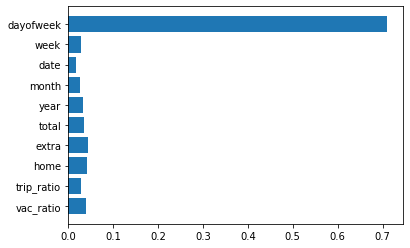

In [ ]:
plt.barh(lunch_X.columns, lunch_xgb_model.feature_importances_)

In [ ]:
submission_df = pd.read_csv(PATH + 'sample_submission.csv')
submission_df['중식계'] = lunch_xgb_pred
submission_df['석식계'] = dinner_xgb_pred
submission_df.head()

,일자,중식계,석식계
0,2021-01-27,994.924194,217.514496
1,2021-01-28,919.631409,403.205200
2,2021-01-29,605.236938,246.341095
3,2021-02-01,1255.268433,498.184448
4,2021-02-02,953.854919,433.412964


In [ ]:
submission_df.to_csv(PATH + 'xgb_base2.csv', index=False)

# LightGBM


In [ ]:
 sampler = TPESampler(seed=10)
 def objective(trial):

     param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

     lgbm_regr = lgb.LGBMRegressor(**param)
     lgbm = lgbm_regr.fit(l_X_train, l_y_train , eval_set = [(l_X_train, l_y_train)], verbose=False)
     mae = mean_absolute_error(l_y_test, lgbm.predict(l_X_test))
     return mae
        
l_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
l_study_lgb.optimize(objective, n_trials=50)

[I 2021-07-03 09:45:30,528] A new study created in memory with name: no-name-59ec12cc-7867-4c2e-9c15-69635dc58dfe


[LightGBM] [Warning] feature_fraction is set=0.5348779873185086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5348779873185086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4656004675652718e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4656004675652718e-08
[LightGBM] [Warning] bagging_fraction is set=0.5188377188557745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5188377188557745
[LightGBM] [Warning] lambda_l1 is set=0.014810344004555135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014810344004555135


[I 2021-07-03 09:45:31,890] Trial 0 finished with value: 168.08836813627406 and parameters: {'lambda_l1': 0.014810344004555135, 'lambda_l2': 1.4656004675652718e-08, 'num_leaves': 254, 'max_depth': 8, 'n_estimators': 2844, 'feature_fraction': 0.5348779873185086, 'bagging_fraction': 0.5188377188557745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 168.08836813627406.


[LightGBM] [Warning] feature_fraction is set=0.8875725769912681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875725769912681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.003040034742832493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003040034742832493
[LightGBM] [Warning] bagging_fraction is set=0.7675156400976328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675156400976328
[LightGBM] [Warning] lambda_l1 is set=5.090008568091192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.090008568091192e-08


[I 2021-07-03 09:45:32,646] Trial 1 finished with value: 68.2245823893435 and parameters: {'lambda_l1': 5.090008568091192e-08, 'lambda_l2': 0.003040034742832493, 'num_leaves': 382, 'max_depth': 3, 'n_estimators': 2902, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8044801690398071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044801690398071
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.005207224083783965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005207224083783965
[LightGBM] [Warning] bagging_fraction is set=0.6650999046537976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650999046537976
[LightGBM] [Warning] lambda_l1 is set=0.21988367156694333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21988367156694333


[I 2021-07-03 09:45:33,185] Trial 2 finished with value: 73.67051522366995 and parameters: {'lambda_l1': 0.21988367156694333, 'lambda_l2': 0.005207224083783965, 'num_leaves': 218, 'max_depth': 3, 'n_estimators': 2305, 'feature_fraction': 0.8044801690398071, 'bagging_fraction': 0.6650999046537976, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.945189328485201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945189328485201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0015965313667163816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015965313667163816
[LightGBM] [Warning] bagging_fraction is set=0.5915416533931271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915416533931271
[LightGBM] [Warning] lambda_l1 is set=0.00012738137732610437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012738137732610437


[I 2021-07-03 09:45:34,549] Trial 3 finished with value: 70.80919003939353 and parameters: {'lambda_l1': 0.00012738137732610437, 'lambda_l2': 0.0015965313667163816, 'num_leaves': 241, 'max_depth': 8, 'n_estimators': 2943, 'feature_fraction': 0.945189328485201, 'bagging_fraction': 0.5915416533931271, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8915721974020412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8915721974020412
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.042604022999246406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042604022999246406
[LightGBM] [Warning] bagging_fraction is set=0.5193685238072874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5193685238072874
[LightGBM] [Warning] lambda_l1 is set=8.163471763379958e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.163471763379958e-08


[I 2021-07-03 09:45:35,633] Trial 4 finished with value: 78.27357533205227 and parameters: {'lambda_l1': 8.163471763379958e-08, 'lambda_l2': 0.042604022999246406, 'num_leaves': 20, 'max_depth': 7, 'n_estimators': 3055, 'feature_fraction': 0.8915721974020412, 'bagging_fraction': 0.5193685238072874, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.6355175463679523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6355175463679523
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3318126555538504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3318126555538504e-06
[LightGBM] [Warning] bagging_fraction is set=0.4560762247351902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560762247351902
[LightGBM] [Warning] lambda_l1 is set=0.010893853540963833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010893853540963833


[I 2021-07-03 09:45:36,233] Trial 5 finished with value: 167.7616691311999 and parameters: {'lambda_l1': 0.010893853540963833, 'lambda_l2': 2.3318126555538504e-06, 'num_leaves': 354, 'max_depth': 5, 'n_estimators': 1409, 'feature_fraction': 0.6355175463679523, 'bagging_fraction': 0.4560762247351902, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.5508244805242356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508244805242356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3581671060741645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3581671060741645
[LightGBM] [Warning] bagging_fraction is set=0.7584229889385306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584229889385306
[LightGBM] [Warning] lambda_l1 is set=1.1828116394242723e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1828116394242723e-05


[I 2021-07-03 09:45:37,607] Trial 6 finished with value: 80.8529806502653 and parameters: {'lambda_l1': 1.1828116394242723e-05, 'lambda_l2': 0.3581671060741645, 'num_leaves': 396, 'max_depth': 6, 'n_estimators': 4253, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.5984315871892792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984315871892792
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0618360930258403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0618360930258403e-08
[LightGBM] [Warning] bagging_fraction is set=0.8642981777263575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642981777263575
[LightGBM] [Warning] lambda_l1 is set=0.0005267577135346555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005267577135346555


[I 2021-07-03 09:45:38,123] Trial 7 finished with value: 168.088589155563 and parameters: {'lambda_l1': 0.0005267577135346555, 'lambda_l2': 2.0618360930258403e-08, 'num_leaves': 144, 'max_depth': 3, 'n_estimators': 2013, 'feature_fraction': 0.5984315871892792, 'bagging_fraction': 0.8642981777263575, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8579443522862087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8579443522862087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0012357458041729475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012357458041729475
[LightGBM] [Warning] bagging_fraction is set=0.926857985634915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926857985634915
[LightGBM] [Warning] lambda_l1 is set=3.3068536483753737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3068536483753737e-06


[I 2021-07-03 09:45:39,328] Trial 8 finished with value: 73.11536522279569 and parameters: {'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 1 with value: 68.2245823893435.
[I 2021-07-03 09:45:39,519] Trial 9 finished with value: 134.33553544821945 and parameters: {'lambda_l1': 0.0001281542517497079, 'lambda_l2': 0.0006063078395671604, 'num_leaves': 106, 'max_depth': 5, 'n_estimators': 809, 'feature_fraction': 0.5818375363906209, 'bagging_fraction': 0.5452455252421164, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.5818375363906209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818375363906209
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006063078395671604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006063078395671604
[LightGBM] [Warning] bagging_fraction is set=0.5452455252421164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5452455252421164
[LightGBM] [Warning] lambda_l1 is set=0.0001281542517497079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001281542517497079
[LightGBM] [Warning] feature_fraction is set=0.7649442484108072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649442484108072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.0104793324

[I 2021-07-03 09:45:40,422] Trial 10 finished with value: 167.0844404823267 and parameters: {'lambda_l1': 1.6785873892849563e-08, 'lambda_l2': 3.010479332494921e-06, 'num_leaves': 341, 'max_depth': 4, 'n_estimators': 3558, 'feature_fraction': 0.7649442484108072, 'bagging_fraction': 0.7880669612015251, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9991122238129395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991122238129395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.61939793719469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.61939793719469e-05
[LightGBM] [Warning] bagging_fraction is set=0.6585514682875593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585514682875593
[LightGBM] [Warning] lambda_l1 is set=8.9826258759353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.9826258759353e-07


[I 2021-07-03 09:45:45,589] Trial 11 finished with value: 156.59219682334364 and parameters: {'lambda_l1': 8.9826258759353e-07, 'lambda_l2': 2.61939793719469e-05, 'num_leaves': 287, 'max_depth': 9, 'n_estimators': 3632, 'feature_fraction': 0.9991122238129395, 'bagging_fraction': 0.6585514682875593, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9922869658927289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922869658927289
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.030766178350701442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030766178350701442
[LightGBM] [Warning] bagging_fraction is set=0.6307116556352568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6307116556352568
[LightGBM] [Warning] lambda_l1 is set=0.0010032552297938406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010032552297938406


[I 2021-07-03 09:45:46,945] Trial 12 finished with value: 74.22269527381991 and parameters: {'lambda_l1': 0.0010032552297938406, 'lambda_l2': 0.030766178350701442, 'num_leaves': 311, 'max_depth': 9, 'n_estimators': 2453, 'feature_fraction': 0.9922869658927289, 'bagging_fraction': 0.6307116556352568, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.41844661211798795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41844661211798795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00015468424548794194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015468424548794194
[LightGBM] [Warning] bagging_fraction is set=0.995679260563783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995679260563783
[LightGBM] [Warning] lambda_l1 is set=1.9886276185414409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9886276185414409e-07


[I 2021-07-03 09:45:50,725] Trial 13 finished with value: 127.29066396606996 and parameters: {'lambda_l1': 1.9886276185414409e-07, 'lambda_l2': 0.00015468424548794194, 'num_leaves': 387, 'max_depth': 7, 'n_estimators': 3556, 'feature_fraction': 0.41844661211798795, 'bagging_fraction': 0.995679260563783, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9290019894565231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9290019894565231
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9773722751809201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9773722751809201
[LightGBM] [Warning] bagging_fraction is set=0.750295356922126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750295356922126
[LightGBM] [Warning] lambda_l1 is set=2.8821931552561775e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8821931552561775e-05


[I 2021-07-03 09:45:51,767] Trial 14 finished with value: 99.66860342433343 and parameters: {'lambda_l1': 2.8821931552561775e-05, 'lambda_l2': 0.9773722751809201, 'num_leaves': 219, 'max_depth': 8, 'n_estimators': 1756, 'feature_fraction': 0.9290019894565231, 'bagging_fraction': 0.750295356922126, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.7285367937084144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7285367937084144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.013133026541985783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013133026541985783
[LightGBM] [Warning] bagging_fraction is set=0.5989394570002292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5989394570002292
[LightGBM] [Warning] lambda_l1 is set=1.0885522537644062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0885522537644062e-08


[I 2021-07-03 09:45:52,796] Trial 15 finished with value: 70.82605705543644 and parameters: {'lambda_l1': 1.0885522537644062e-08, 'lambda_l2': 0.013133026541985783, 'num_leaves': 28, 'max_depth': 7, 'n_estimators': 3001, 'feature_fraction': 0.7285367937084144, 'bagging_fraction': 0.5989394570002292, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9592124084612702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592124084612702
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4319355308173353e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4319355308173353e-05
[LightGBM] [Warning] bagging_fraction is set=0.4072835615446248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072835615446248
[LightGBM] [Warning] lambda_l1 is set=0.006757265265334436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006757265265334436


[I 2021-07-03 09:45:53,431] Trial 16 finished with value: 160.12652768803702 and parameters: {'lambda_l1': 0.006757265265334436, 'lambda_l2': 3.4319355308173353e-05, 'num_leaves': 266, 'max_depth': 8, 'n_estimators': 2583, 'feature_fraction': 0.9592124084612702, 'bagging_fraction': 0.4072835615446248, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8133108831404763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133108831404763
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.19063245323117958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19063245323117958
[LightGBM] [Warning] bagging_fraction is set=0.8359226382813782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359226382813782
[LightGBM] [Warning] lambda_l1 is set=0.4749952337893574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4749952337893574


[I 2021-07-03 09:45:55,146] Trial 17 finished with value: 75.38167518057081 and parameters: {'lambda_l1': 0.4749952337893574, 'lambda_l2': 0.19063245323117958, 'num_leaves': 163, 'max_depth': 5, 'n_estimators': 3778, 'feature_fraction': 0.8133108831404763, 'bagging_fraction': 0.8359226382813782, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9049229635967819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9049229635967819
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0038947940771188595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038947940771188595
[LightGBM] [Warning] bagging_fraction is set=0.7133340635208179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133340635208179
[LightGBM] [Warning] lambda_l1 is set=6.162473122054843e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.162473122054843e-05


[I 2021-07-03 09:45:57,195] Trial 18 finished with value: 68.25159573580302 and parameters: {'lambda_l1': 6.162473122054843e-05, 'lambda_l2': 0.0038947940771188595, 'num_leaves': 63, 'max_depth': 6, 'n_estimators': 4956, 'feature_fraction': 0.9049229635967819, 'bagging_fraction': 0.7133340635208179, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.6694741937620116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694741937620116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00017090105110919117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017090105110919117
[LightGBM] [Warning] bagging_fraction is set=0.7102315542302928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7102315542302928
[LightGBM] [Warning] lambda_l1 is set=1.558826272807897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.558826272807897e-06


[I 2021-07-03 09:45:58,996] Trial 19 finished with value: 112.40814959477449 and parameters: {'lambda_l1': 1.558826272807897e-06, 'lambda_l2': 0.00017090105110919117, 'num_leaves': 88, 'max_depth': 6, 'n_estimators': 4901, 'feature_fraction': 0.6694741937620116, 'bagging_fraction': 0.7102315542302928, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8830528000666321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8830528000666321
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.005399216065659898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005399216065659898
[LightGBM] [Warning] bagging_fraction is set=0.8981126396254016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8981126396254016
[LightGBM] [Warning] lambda_l1 is set=8.577543141688918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.577543141688918e-08


[I 2021-07-03 09:46:00,363] Trial 20 finished with value: 69.81787156647374 and parameters: {'lambda_l1': 8.577543141688918e-08, 'lambda_l2': 0.005399216065659898, 'num_leaves': 57, 'max_depth': 4, 'n_estimators': 4914, 'feature_fraction': 0.8830528000666321, 'bagging_fraction': 0.8981126396254016, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.857435008067406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.857435008067406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.007085955366616683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007085955366616683
[LightGBM] [Warning] bagging_fraction is set=0.9541820918740274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9541820918740274
[LightGBM] [Warning] lambda_l1 is set=1.3637885278895198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3637885278895198e-07


[I 2021-07-03 09:46:01,715] Trial 21 finished with value: 72.07557604930169 and parameters: {'lambda_l1': 1.3637885278895198e-07, 'lambda_l2': 0.007085955366616683, 'num_leaves': 64, 'max_depth': 4, 'n_estimators': 4860, 'feature_fraction': 0.857435008067406, 'bagging_fraction': 0.9541820918740274, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8896961138855114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896961138855114
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.1440306548213092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1440306548213092
[LightGBM] [Warning] bagging_fraction is set=0.8719479103382188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8719479103382188
[LightGBM] [Warning] lambda_l1 is set=1.117885124030037e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.117885124030037e-08


[I 2021-07-03 09:46:02,909] Trial 22 finished with value: 79.82043715241834 and parameters: {'lambda_l1': 1.117885124030037e-08, 'lambda_l2': 0.1440306548213092, 'num_leaves': 49, 'max_depth': 4, 'n_estimators': 4443, 'feature_fraction': 0.8896961138855114, 'bagging_fraction': 0.8719479103382188, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.797585277438908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797585277438908
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00286882006173601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00286882006173601
[LightGBM] [Warning] bagging_fraction is set=0.8340528532958039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8340528532958039
[LightGBM] [Warning] lambda_l1 is set=4.4206330381302414e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4206330381302414e-07


[I 2021-07-03 09:46:04,272] Trial 23 finished with value: 70.4626573453293 and parameters: {'lambda_l1': 4.4206330381302414e-07, 'lambda_l2': 0.00286882006173601, 'num_leaves': 180, 'max_depth': 4, 'n_estimators': 4963, 'feature_fraction': 0.797585277438908, 'bagging_fraction': 0.8340528532958039, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9082255084550924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9082255084550924
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0004910285788460762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004910285788460762
[LightGBM] [Warning] bagging_fraction is set=0.7131579822782704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7131579822782704
[LightGBM] [Warning] lambda_l1 is set=5.3211789024334075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3211789024334075e-08


[I 2021-07-03 09:46:05,747] Trial 24 finished with value: 83.35697281125313 and parameters: {'lambda_l1': 5.3211789024334075e-08, 'lambda_l2': 0.0004910285788460762, 'num_leaves': 114, 'max_depth': 5, 'n_estimators': 4092, 'feature_fraction': 0.9082255084550924, 'bagging_fraction': 0.7131579822782704, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8525645941267856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8525645941267856
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.03461833732184834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03461833732184834
[LightGBM] [Warning] bagging_fraction is set=0.9186670114421646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9186670114421646
[LightGBM] [Warning] lambda_l1 is set=9.627153081826672e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.627153081826672e-06


[I 2021-07-03 09:46:06,914] Trial 25 finished with value: 73.17524387491486 and parameters: {'lambda_l1': 9.627153081826672e-06, 'lambda_l2': 0.03461833732184834, 'num_leaves': 70, 'max_depth': 3, 'n_estimators': 4664, 'feature_fraction': 0.8525645941267856, 'bagging_fraction': 0.9186670114421646, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 1 with value: 68.2245823893435.
[I 2021-07-03 09:46:07,080] Trial 26 finished with value: 165.79104295387324 and parameters: {'lambda_l1': 3.617654385059622e-08, 'lambda_l2': 3.21018883782884e-05, 'num_leaves': 3, 'max_depth': 6, 'n_estimators': 922, 'feature_fraction': 0.7208616598347489, 'bagging_fraction': 0.8051944778854442, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.7208616598347489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7208616598347489
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.21018883782884e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.21018883782884e-05
[LightGBM] [Warning] bagging_fraction is set=0.8051944778854442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051944778854442
[LightGBM] [Warning] lambda_l1 is set=3.617654385059622e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.617654385059622e-08
[LightGBM] [Warning] feature_fraction is set=0.978823807556182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978823807556182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00762388412587

[I 2021-07-03 09:46:08,380] Trial 27 finished with value: 68.31447930080783 and parameters: {'lambda_l1': 3.5202198902227952e-06, 'lambda_l2': 0.007623884125877974, 'num_leaves': 37, 'max_depth': 4, 'n_estimators': 3928, 'feature_fraction': 0.978823807556182, 'bagging_fraction': 0.7586217334270403, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.983261850180457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.983261850180457
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.06153077564466302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06153077564466302
[LightGBM] [Warning] bagging_fraction is set=0.7478638044077373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478638044077373
[LightGBM] [Warning] lambda_l1 is set=2.6713597683041026e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6713597683041026e-05


[I 2021-07-03 09:46:10,110] Trial 28 finished with value: 73.37228600318362 and parameters: {'lambda_l1': 2.6713597683041026e-05, 'lambda_l2': 0.06153077564466302, 'num_leaves': 30, 'max_depth': 5, 'n_estimators': 4001, 'feature_fraction': 0.983261850180457, 'bagging_fraction': 0.7478638044077373, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.4467465826790745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4467465826790745
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00036096976564155053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036096976564155053
[LightGBM] [Warning] bagging_fraction is set=0.672679532303821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.672679532303821
[LightGBM] [Warning] lambda_l1 is set=0.0008411698071306363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008411698071306363


[I 2021-07-03 09:46:10,646] Trial 29 finished with value: 118.29020494785748 and parameters: {'lambda_l1': 0.0008411698071306363, 'lambda_l2': 0.00036096976564155053, 'num_leaves': 3, 'max_depth': 7, 'n_estimators': 3251, 'feature_fraction': 0.4467465826790745, 'bagging_fraction': 0.672679532303821, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.9485639040314328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9485639040314328
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9330264060741632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9330264060741632
[LightGBM] [Warning] bagging_fraction is set=0.7907252411951584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907252411951584
[LightGBM] [Warning] lambda_l1 is set=5.238685512402491e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.238685512402491e-06


[I 2021-07-03 09:46:11,503] Trial 30 finished with value: 103.94130317065652 and parameters: {'lambda_l1': 5.238685512402491e-06, 'lambda_l2': 0.9330264060741632, 'num_leaves': 113, 'max_depth': 6, 'n_estimators': 3337, 'feature_fraction': 0.9485639040314328, 'bagging_fraction': 0.7907252411951584, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.8456039224486642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456039224486642
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.011681208582494407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011681208582494407
[LightGBM] [Warning] bagging_fraction is set=0.712747098225565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712747098225565
[LightGBM] [Warning] lambda_l1 is set=4.1883465875895746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1883465875895746e-07


[I 2021-07-03 09:46:12,701] Trial 31 finished with value: 69.7380789666321 and parameters: {'lambda_l1': 4.1883465875895746e-07, 'lambda_l2': 0.011681208582494407, 'num_leaves': 48, 'max_depth': 4, 'n_estimators': 3929, 'feature_fraction': 0.8456039224486642, 'bagging_fraction': 0.712747098225565, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 1 with value: 68.2245823893435.


[LightGBM] [Warning] feature_fraction is set=0.7753150238928894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7753150238928894
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.009843900884763586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009843900884763586
[LightGBM] [Warning] bagging_fraction is set=0.7033300787966946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7033300787966946
[LightGBM] [Warning] lambda_l1 is set=6.933439446112878e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.933439446112878e-07


[I 2021-07-03 09:46:13,676] Trial 32 finished with value: 67.77519885281583 and parameters: {'lambda_l1': 6.933439446112878e-07, 'lambda_l2': 0.009843900884763586, 'num_leaves': 95, 'max_depth': 3, 'n_estimators': 3908, 'feature_fraction': 0.7753150238928894, 'bagging_fraction': 0.7033300787966946, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 32 with value: 67.77519885281583.


[LightGBM] [Warning] feature_fraction is set=0.770900940963003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.770900940963003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.002349695193344987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002349695193344987
[LightGBM] [Warning] bagging_fraction is set=0.6634893230016086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634893230016086
[LightGBM] [Warning] lambda_l1 is set=1.2412526223857976e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2412526223857976e-06


[I 2021-07-03 09:46:14,367] Trial 33 finished with value: 69.45398282377937 and parameters: {'lambda_l1': 1.2412526223857976e-06, 'lambda_l2': 0.002349695193344987, 'num_leaves': 83, 'max_depth': 3, 'n_estimators': 2728, 'feature_fraction': 0.770900940963003, 'bagging_fraction': 0.6634893230016086, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 32 with value: 67.77519885281583.


[LightGBM] [Warning] feature_fraction is set=0.8109698082278238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8109698082278238
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0012066704851500033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012066704851500033
[LightGBM] [Warning] bagging_fraction is set=0.7483332174356776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7483332174356776
[LightGBM] [Warning] lambda_l1 is set=4.17692130190505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.17692130190505e-05


[I 2021-07-03 09:46:14,977] Trial 34 finished with value: 83.75409302531094 and parameters: {'lambda_l1': 4.17692130190505e-05, 'lambda_l2': 0.0012066704851500033, 'num_leaves': 3, 'max_depth': 3, 'n_estimators': 3280, 'feature_fraction': 0.8109698082278238, 'bagging_fraction': 0.7483332174356776, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 32 with value: 67.77519885281583.


[LightGBM] [Warning] feature_fraction is set=0.9242757612217026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242757612217026
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.015967861745800383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015967861745800383
[LightGBM] [Warning] bagging_fraction is set=0.6201655597229148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6201655597229148
[LightGBM] [Warning] lambda_l1 is set=3.0925815695686164e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0925815695686164e-06


[I 2021-07-03 09:46:16,094] Trial 35 finished with value: 69.40967229893587 and parameters: {'lambda_l1': 3.0925815695686164e-06, 'lambda_l2': 0.015967861745800383, 'num_leaves': 125, 'max_depth': 3, 'n_estimators': 4367, 'feature_fraction': 0.9242757612217026, 'bagging_fraction': 0.6201655597229148, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 32 with value: 67.77519885281583.


[LightGBM] [Warning] feature_fraction is set=0.9689976512076663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689976512076663
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.07728059834779502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07728059834779502
[LightGBM] [Warning] bagging_fraction is set=0.6801525970382309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6801525970382309
[LightGBM] [Warning] lambda_l1 is set=0.00023035809545990645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023035809545990645


[I 2021-07-03 09:46:16,705] Trial 36 finished with value: 73.53002867018955 and parameters: {'lambda_l1': 0.00023035809545990645, 'lambda_l2': 0.07728059834779502, 'num_leaves': 180, 'max_depth': 3, 'n_estimators': 2298, 'feature_fraction': 0.9689976512076663, 'bagging_fraction': 0.6801525970382309, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 32 with value: 67.77519885281583.


[LightGBM] [Warning] feature_fraction is set=0.6799896576109249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6799896576109249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00365564781783537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00365564781783537
[LightGBM] [Warning] bagging_fraction is set=0.8187865503548556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187865503548556
[LightGBM] [Warning] lambda_l1 is set=2.897285138402634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897285138402634e-07


[I 2021-07-03 09:46:18,158] Trial 37 finished with value: 65.47700831201462 and parameters: {'lambda_l1': 2.897285138402634e-07, 'lambda_l2': 0.00365564781783537, 'num_leaves': 89, 'max_depth': 4, 'n_estimators': 4170, 'feature_fraction': 0.6799896576109249, 'bagging_fraction': 0.8187865503548556, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6305292483774079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305292483774079
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.003988285558711171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003988285558711171
[LightGBM] [Warning] bagging_fraction is set=0.8382605479138953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8382605479138953
[LightGBM] [Warning] lambda_l1 is set=0.08103833153437869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08103833153437869


[I 2021-07-03 09:46:19,940] Trial 38 finished with value: 66.5813999610059 and parameters: {'lambda_l1': 0.08103833153437869, 'lambda_l2': 0.003988285558711171, 'num_leaves': 92, 'max_depth': 5, 'n_estimators': 4176, 'feature_fraction': 0.6305292483774079, 'bagging_fraction': 0.8382605479138953, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6545599625224247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545599625224247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.001337440493169704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001337440493169704
[LightGBM] [Warning] bagging_fraction is set=0.7917239084922874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917239084922874
[LightGBM] [Warning] lambda_l1 is set=0.037113466772583696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.037113466772583696


[I 2021-07-03 09:46:21,950] Trial 39 finished with value: 68.12675992566635 and parameters: {'lambda_l1': 0.037113466772583696, 'lambda_l2': 0.001337440493169704, 'num_leaves': 88, 'max_depth': 5, 'n_estimators': 4235, 'feature_fraction': 0.6545599625224247, 'bagging_fraction': 0.7917239084922874, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6572490301121829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572490301121829
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.147565815887788e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.147565815887788e-05
[LightGBM] [Warning] bagging_fraction is set=0.843060285702147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843060285702147
[LightGBM] [Warning] lambda_l1 is set=0.1417946961934106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1417946961934106


[I 2021-07-03 09:46:24,272] Trial 40 finished with value: 143.37047718438484 and parameters: {'lambda_l1': 0.1417946961934106, 'lambda_l2': 6.147565815887788e-05, 'num_leaves': 94, 'max_depth': 5, 'n_estimators': 4189, 'feature_fraction': 0.6572490301121829, 'bagging_fraction': 0.843060285702147, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.5008785352223447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5008785352223447
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0010207127649325268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010207127649325268
[LightGBM] [Warning] bagging_fraction is set=0.8111461277730591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111461277730591
[LightGBM] [Warning] lambda_l1 is set=0.08071802526324821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08071802526324821


[I 2021-07-03 09:46:26,367] Trial 41 finished with value: 69.76879254295662 and parameters: {'lambda_l1': 0.08071802526324821, 'lambda_l2': 0.0010207127649325268, 'num_leaves': 137, 'max_depth': 5, 'n_estimators': 4541, 'feature_fraction': 0.5008785352223447, 'bagging_fraction': 0.8111461277730591, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6199850230421977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6199850230421977
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00029869339456754064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029869339456754064
[LightGBM] [Warning] bagging_fraction is set=0.780120266936442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780120266936442
[LightGBM] [Warning] lambda_l1 is set=0.045271139462990745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045271139462990745


[I 2021-07-03 09:46:28,158] Trial 42 finished with value: 91.99812603562292 and parameters: {'lambda_l1': 0.045271139462990745, 'lambda_l2': 0.00029869339456754064, 'num_leaves': 154, 'max_depth': 4, 'n_estimators': 4708, 'feature_fraction': 0.6199850230421977, 'bagging_fraction': 0.780120266936442, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6861358517564461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6861358517564461
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0024930661642714636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024930661642714636
[LightGBM] [Warning] bagging_fraction is set=0.8818295361642811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8818295361642811
[LightGBM] [Warning] lambda_l1 is set=0.5816949305710215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5816949305710215


[I 2021-07-03 09:46:30,016] Trial 43 finished with value: 65.95959291306336 and parameters: {'lambda_l1': 0.5816949305710215, 'lambda_l2': 0.0024930661642714636, 'num_leaves': 91, 'max_depth': 5, 'n_estimators': 3732, 'feature_fraction': 0.6861358517564461, 'bagging_fraction': 0.8818295361642811, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.694649336674864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.694649336674864
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0015487656142613338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015487656142613338
[LightGBM] [Warning] bagging_fraction is set=0.8904034644477615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8904034644477615
[LightGBM] [Warning] lambda_l1 is set=0.004451746482349735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004451746482349735


[I 2021-07-03 09:46:32,242] Trial 44 finished with value: 66.0828160805039 and parameters: {'lambda_l1': 0.004451746482349735, 'lambda_l2': 0.0015487656142613338, 'num_leaves': 94, 'max_depth': 5, 'n_estimators': 4296, 'feature_fraction': 0.694649336674864, 'bagging_fraction': 0.8904034644477615, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6912647996827558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6912647996827558
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0022411177210349058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022411177210349058
[LightGBM] [Warning] bagging_fraction is set=0.9692205317999674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9692205317999674
[LightGBM] [Warning] lambda_l1 is set=0.97409057602456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.97409057602456


[I 2021-07-03 09:46:34,298] Trial 45 finished with value: 66.54621693719595 and parameters: {'lambda_l1': 0.97409057602456, 'lambda_l2': 0.0022411177210349058, 'num_leaves': 129, 'max_depth': 5, 'n_estimators': 3497, 'feature_fraction': 0.6912647996827558, 'bagging_fraction': 0.9692205317999674, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6907857835302649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6907857835302649
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.002293955675468287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002293955675468287
[LightGBM] [Warning] bagging_fraction is set=0.9840748545936858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840748545936858
[LightGBM] [Warning] lambda_l1 is set=0.911386313567701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.911386313567701


[I 2021-07-03 09:46:36,254] Trial 46 finished with value: 65.73120733570985 and parameters: {'lambda_l1': 0.911386313567701, 'lambda_l2': 0.002293955675468287, 'num_leaves': 126, 'max_depth': 5, 'n_estimators': 3688, 'feature_fraction': 0.6907857835302649, 'bagging_fraction': 0.9840748545936858, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.6894291505793495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6894291505793495
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.243222172966609e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.243222172966609e-06
[LightGBM] [Warning] bagging_fraction is set=0.9933142319078488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9933142319078488
[LightGBM] [Warning] lambda_l1 is set=0.7723357260574077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7723357260574077


[I 2021-07-03 09:46:38,548] Trial 47 finished with value: 164.691249318221 and parameters: {'lambda_l1': 0.7723357260574077, 'lambda_l2': 8.243222172966609e-06, 'num_leaves': 124, 'max_depth': 5, 'n_estimators': 3741, 'feature_fraction': 0.6894291505793495, 'bagging_fraction': 0.9933142319078488, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.7077509504125293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077509504125293
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0007823504051765781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007823504051765781
[LightGBM] [Warning] bagging_fraction is set=0.9652566499690516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9652566499690516
[LightGBM] [Warning] lambda_l1 is set=0.3077454896035705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077454896035705


[I 2021-07-03 09:46:41,821] Trial 48 finished with value: 72.76843848555889 and parameters: {'lambda_l1': 0.3077454896035705, 'lambda_l2': 0.0007823504051765781, 'num_leaves': 206, 'max_depth': 6, 'n_estimators': 3469, 'feature_fraction': 0.7077509504125293, 'bagging_fraction': 0.9652566499690516, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 37 with value: 65.47700831201462.


[LightGBM] [Warning] feature_fraction is set=0.7369313686767585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369313686767585
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7820979457059422e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7820979457059422e-07
[LightGBM] [Warning] bagging_fraction is set=0.958285045095513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.958285045095513
[LightGBM] [Warning] lambda_l1 is set=0.006696428249371957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006696428249371957


[I 2021-07-03 09:46:44,079] Trial 49 finished with value: 168.01796158020093 and parameters: {'lambda_l1': 0.006696428249371957, 'lambda_l2': 1.7820979457059422e-07, 'num_leaves': 177, 'max_depth': 5, 'n_estimators': 3740, 'feature_fraction': 0.7369313686767585, 'bagging_fraction': 0.958285045095513, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 37 with value: 65.47700831201462.


In [ ]:
 sampler = TPESampler(seed=10)
 def objective(trial):

     param = {
         'objective': 'regression', # 회귀
         'metric': 'mae', 
         'verbosity': -1,
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

     lgbm_regr = lgb.LGBMRegressor(**param)
     lgbm = lgbm_regr.fit(d_X_train, d_y_train , eval_set = [(d_X_train, d_y_train)], verbose=False)
     mae = mean_absolute_error(d_y_test, lgbm.predict(d_X_test))
     return mae
        
d_study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
d_study_lgb.optimize(objective, n_trials=50)

[I 2021-07-03 09:46:44,107] A new study created in memory with name: no-name-cd3128f2-f5f0-4590-9022-efe33303dc43


[LightGBM] [Warning] feature_fraction is set=0.5348779873185086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5348779873185086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4656004675652718e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4656004675652718e-08
[LightGBM] [Warning] bagging_fraction is set=0.5188377188557745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5188377188557745
[LightGBM] [Warning] lambda_l1 is set=0.014810344004555135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014810344004555135


[I 2021-07-03 09:46:45,565] Trial 0 finished with value: 102.27037999911656 and parameters: {'lambda_l1': 0.014810344004555135, 'lambda_l2': 1.4656004675652718e-08, 'num_leaves': 254, 'max_depth': 8, 'n_estimators': 2844, 'feature_fraction': 0.5348779873185086, 'bagging_fraction': 0.5188377188557745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 102.27037999911656.


[LightGBM] [Warning] feature_fraction is set=0.8875725769912681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875725769912681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.003040034742832493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003040034742832493
[LightGBM] [Warning] bagging_fraction is set=0.7675156400976328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675156400976328
[LightGBM] [Warning] lambda_l1 is set=5.090008568091192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.090008568091192e-08


[I 2021-07-03 09:46:46,345] Trial 1 finished with value: 50.88575106945658 and parameters: {'lambda_l1': 5.090008568091192e-08, 'lambda_l2': 0.003040034742832493, 'num_leaves': 382, 'max_depth': 3, 'n_estimators': 2902, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8044801690398071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044801690398071
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.005207224083783965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005207224083783965
[LightGBM] [Warning] bagging_fraction is set=0.6650999046537976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650999046537976
[LightGBM] [Warning] lambda_l1 is set=0.21988367156694333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21988367156694333


[I 2021-07-03 09:46:46,881] Trial 2 finished with value: 56.39333400168846 and parameters: {'lambda_l1': 0.21988367156694333, 'lambda_l2': 0.005207224083783965, 'num_leaves': 218, 'max_depth': 3, 'n_estimators': 2305, 'feature_fraction': 0.8044801690398071, 'bagging_fraction': 0.6650999046537976, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.945189328485201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945189328485201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0015965313667163816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015965313667163816
[LightGBM] [Warning] bagging_fraction is set=0.5915416533931271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915416533931271
[LightGBM] [Warning] lambda_l1 is set=0.00012738137732610437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012738137732610437


[I 2021-07-03 09:46:48,277] Trial 3 finished with value: 52.97165045557678 and parameters: {'lambda_l1': 0.00012738137732610437, 'lambda_l2': 0.0015965313667163816, 'num_leaves': 241, 'max_depth': 8, 'n_estimators': 2943, 'feature_fraction': 0.945189328485201, 'bagging_fraction': 0.5915416533931271, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8915721974020412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8915721974020412
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.042604022999246406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042604022999246406
[LightGBM] [Warning] bagging_fraction is set=0.5193685238072874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5193685238072874
[LightGBM] [Warning] lambda_l1 is set=8.163471763379958e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.163471763379958e-08


[I 2021-07-03 09:46:49,387] Trial 4 finished with value: 57.87950806994835 and parameters: {'lambda_l1': 8.163471763379958e-08, 'lambda_l2': 0.042604022999246406, 'num_leaves': 20, 'max_depth': 7, 'n_estimators': 3055, 'feature_fraction': 0.8915721974020412, 'bagging_fraction': 0.5193685238072874, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.6355175463679523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6355175463679523
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3318126555538504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3318126555538504e-06
[LightGBM] [Warning] bagging_fraction is set=0.4560762247351902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560762247351902
[LightGBM] [Warning] lambda_l1 is set=0.010893853540963833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010893853540963833


[I 2021-07-03 09:46:50,003] Trial 5 finished with value: 102.09636719794584 and parameters: {'lambda_l1': 0.010893853540963833, 'lambda_l2': 2.3318126555538504e-06, 'num_leaves': 354, 'max_depth': 5, 'n_estimators': 1409, 'feature_fraction': 0.6355175463679523, 'bagging_fraction': 0.4560762247351902, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.5508244805242356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508244805242356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3581671060741645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3581671060741645
[LightGBM] [Warning] bagging_fraction is set=0.7584229889385306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584229889385306
[LightGBM] [Warning] lambda_l1 is set=1.1828116394242723e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1828116394242723e-05


[I 2021-07-03 09:46:51,413] Trial 6 finished with value: 59.6568606510387 and parameters: {'lambda_l1': 1.1828116394242723e-05, 'lambda_l2': 0.3581671060741645, 'num_leaves': 396, 'max_depth': 6, 'n_estimators': 4253, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.5984315871892792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984315871892792
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0618360930258403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0618360930258403e-08
[LightGBM] [Warning] bagging_fraction is set=0.8642981777263575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642981777263575
[LightGBM] [Warning] lambda_l1 is set=0.0005267577135346555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005267577135346555


[I 2021-07-03 09:46:51,920] Trial 7 finished with value: 102.2706028172915 and parameters: {'lambda_l1': 0.0005267577135346555, 'lambda_l2': 2.0618360930258403e-08, 'num_leaves': 144, 'max_depth': 3, 'n_estimators': 2013, 'feature_fraction': 0.5984315871892792, 'bagging_fraction': 0.8642981777263575, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8579443522862087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8579443522862087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0012357458041729475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012357458041729475
[LightGBM] [Warning] bagging_fraction is set=0.926857985634915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926857985634915
[LightGBM] [Warning] lambda_l1 is set=3.3068536483753737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3068536483753737e-06


[I 2021-07-03 09:46:53,077] Trial 8 finished with value: 56.0349205798433 and parameters: {'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 1 with value: 50.88575106945658.
[I 2021-07-03 09:46:53,281] Trial 9 finished with value: 84.91992666873385 and parameters: {'lambda_l1': 0.0001281542517497079, 'lambda_l2': 0.0006063078395671604, 'num_leaves': 106, 'max_depth': 5, 'n_estimators': 809, 'feature_fraction': 0.5818375363906209, 'bagging_fraction': 0.5452455252421164, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.5818375363906209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818375363906209
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006063078395671604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006063078395671604
[LightGBM] [Warning] bagging_fraction is set=0.5452455252421164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5452455252421164
[LightGBM] [Warning] lambda_l1 is set=0.0001281542517497079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001281542517497079
[LightGBM] [Warning] feature_fraction is set=0.7649442484108072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649442484108072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.0104793324

[I 2021-07-03 09:46:54,255] Trial 10 finished with value: 101.75072755084977 and parameters: {'lambda_l1': 1.6785873892849563e-08, 'lambda_l2': 3.010479332494921e-06, 'num_leaves': 341, 'max_depth': 4, 'n_estimators': 3558, 'feature_fraction': 0.7649442484108072, 'bagging_fraction': 0.7880669612015251, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9991122238129395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991122238129395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.61939793719469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.61939793719469e-05
[LightGBM] [Warning] bagging_fraction is set=0.6585514682875593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585514682875593
[LightGBM] [Warning] lambda_l1 is set=8.9826258759353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.9826258759353e-07


[I 2021-07-03 09:46:59,794] Trial 11 finished with value: 95.91307094748466 and parameters: {'lambda_l1': 8.9826258759353e-07, 'lambda_l2': 2.61939793719469e-05, 'num_leaves': 287, 'max_depth': 9, 'n_estimators': 3632, 'feature_fraction': 0.9991122238129395, 'bagging_fraction': 0.6585514682875593, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9922869658927289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922869658927289
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.030766178350701442, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030766178350701442
[LightGBM] [Warning] bagging_fraction is set=0.6307116556352568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6307116556352568
[LightGBM] [Warning] lambda_l1 is set=0.0010032552297938406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010032552297938406


[I 2021-07-03 09:47:01,190] Trial 12 finished with value: 53.83919682450579 and parameters: {'lambda_l1': 0.0010032552297938406, 'lambda_l2': 0.030766178350701442, 'num_leaves': 311, 'max_depth': 9, 'n_estimators': 2453, 'feature_fraction': 0.9922869658927289, 'bagging_fraction': 0.6307116556352568, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.41844661211798795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41844661211798795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00015468424548794194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015468424548794194
[LightGBM] [Warning] bagging_fraction is set=0.995679260563783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995679260563783
[LightGBM] [Warning] lambda_l1 is set=1.9886276185414409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9886276185414409e-07


[I 2021-07-03 09:47:04,505] Trial 13 finished with value: 77.94775249292114 and parameters: {'lambda_l1': 1.9886276185414409e-07, 'lambda_l2': 0.00015468424548794194, 'num_leaves': 387, 'max_depth': 7, 'n_estimators': 3556, 'feature_fraction': 0.41844661211798795, 'bagging_fraction': 0.995679260563783, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9290019894565231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9290019894565231
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.9773722751809201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9773722751809201
[LightGBM] [Warning] bagging_fraction is set=0.750295356922126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750295356922126
[LightGBM] [Warning] lambda_l1 is set=2.8821931552561775e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8821931552561775e-05


[I 2021-07-03 09:47:05,540] Trial 14 finished with value: 72.58409443808755 and parameters: {'lambda_l1': 2.8821931552561775e-05, 'lambda_l2': 0.9773722751809201, 'num_leaves': 219, 'max_depth': 8, 'n_estimators': 1756, 'feature_fraction': 0.9290019894565231, 'bagging_fraction': 0.750295356922126, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.7285367937084144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7285367937084144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.013133026541985783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013133026541985783
[LightGBM] [Warning] bagging_fraction is set=0.5989394570002292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5989394570002292
[LightGBM] [Warning] lambda_l1 is set=1.0885522537644062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0885522537644062e-08


[I 2021-07-03 09:47:06,620] Trial 15 finished with value: 54.25703202570445 and parameters: {'lambda_l1': 1.0885522537644062e-08, 'lambda_l2': 0.013133026541985783, 'num_leaves': 28, 'max_depth': 7, 'n_estimators': 3001, 'feature_fraction': 0.7285367937084144, 'bagging_fraction': 0.5989394570002292, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9592124084612702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592124084612702
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4319355308173353e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4319355308173353e-05
[LightGBM] [Warning] bagging_fraction is set=0.4072835615446248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072835615446248
[LightGBM] [Warning] lambda_l1 is set=0.006757265265334436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006757265265334436


[I 2021-07-03 09:47:07,209] Trial 16 finished with value: 98.04227709076831 and parameters: {'lambda_l1': 0.006757265265334436, 'lambda_l2': 3.4319355308173353e-05, 'num_leaves': 266, 'max_depth': 8, 'n_estimators': 2583, 'feature_fraction': 0.9592124084612702, 'bagging_fraction': 0.4072835615446248, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8133108831404763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133108831404763
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.19063245323117958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19063245323117958
[LightGBM] [Warning] bagging_fraction is set=0.8359226382813782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359226382813782
[LightGBM] [Warning] lambda_l1 is set=0.4749952337893574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4749952337893574


[I 2021-07-03 09:47:08,922] Trial 17 finished with value: 55.187261816113676 and parameters: {'lambda_l1': 0.4749952337893574, 'lambda_l2': 0.19063245323117958, 'num_leaves': 163, 'max_depth': 5, 'n_estimators': 3778, 'feature_fraction': 0.8133108831404763, 'bagging_fraction': 0.8359226382813782, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9049229635967819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9049229635967819
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0038947940771188595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038947940771188595
[LightGBM] [Warning] bagging_fraction is set=0.7133340635208179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7133340635208179
[LightGBM] [Warning] lambda_l1 is set=6.162473122054843e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.162473122054843e-05


[I 2021-07-03 09:47:10,999] Trial 18 finished with value: 51.788319311042265 and parameters: {'lambda_l1': 6.162473122054843e-05, 'lambda_l2': 0.0038947940771188595, 'num_leaves': 63, 'max_depth': 6, 'n_estimators': 4956, 'feature_fraction': 0.9049229635967819, 'bagging_fraction': 0.7133340635208179, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.6694741937620116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694741937620116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00017090105110919117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017090105110919117
[LightGBM] [Warning] bagging_fraction is set=0.7102315542302928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7102315542302928
[LightGBM] [Warning] lambda_l1 is set=1.558826272807897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.558826272807897e-06


[I 2021-07-03 09:47:12,857] Trial 19 finished with value: 74.03208675888746 and parameters: {'lambda_l1': 1.558826272807897e-06, 'lambda_l2': 0.00017090105110919117, 'num_leaves': 88, 'max_depth': 6, 'n_estimators': 4901, 'feature_fraction': 0.6694741937620116, 'bagging_fraction': 0.7102315542302928, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8830528000666321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8830528000666321
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.005399216065659898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005399216065659898
[LightGBM] [Warning] bagging_fraction is set=0.8981126396254016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8981126396254016
[LightGBM] [Warning] lambda_l1 is set=8.577543141688918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.577543141688918e-08


[I 2021-07-03 09:47:14,264] Trial 20 finished with value: 52.39016149622366 and parameters: {'lambda_l1': 8.577543141688918e-08, 'lambda_l2': 0.005399216065659898, 'num_leaves': 57, 'max_depth': 4, 'n_estimators': 4914, 'feature_fraction': 0.8830528000666321, 'bagging_fraction': 0.8981126396254016, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.857435008067406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.857435008067406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.007085955366616683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007085955366616683
[LightGBM] [Warning] bagging_fraction is set=0.9541820918740274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9541820918740274
[LightGBM] [Warning] lambda_l1 is set=1.3637885278895198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3637885278895198e-07


[I 2021-07-03 09:47:15,644] Trial 21 finished with value: 53.49626144822936 and parameters: {'lambda_l1': 1.3637885278895198e-07, 'lambda_l2': 0.007085955366616683, 'num_leaves': 64, 'max_depth': 4, 'n_estimators': 4860, 'feature_fraction': 0.857435008067406, 'bagging_fraction': 0.9541820918740274, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8896961138855114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896961138855114
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.1440306548213092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1440306548213092
[LightGBM] [Warning] bagging_fraction is set=0.8719479103382188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8719479103382188
[LightGBM] [Warning] lambda_l1 is set=1.117885124030037e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.117885124030037e-08


[I 2021-07-03 09:47:16,849] Trial 22 finished with value: 62.680730159191256 and parameters: {'lambda_l1': 1.117885124030037e-08, 'lambda_l2': 0.1440306548213092, 'num_leaves': 49, 'max_depth': 4, 'n_estimators': 4443, 'feature_fraction': 0.8896961138855114, 'bagging_fraction': 0.8719479103382188, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.797585277438908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797585277438908
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00286882006173601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00286882006173601
[LightGBM] [Warning] bagging_fraction is set=0.8340528532958039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8340528532958039
[LightGBM] [Warning] lambda_l1 is set=4.4206330381302414e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4206330381302414e-07


[I 2021-07-03 09:47:18,237] Trial 23 finished with value: 54.03356394449385 and parameters: {'lambda_l1': 4.4206330381302414e-07, 'lambda_l2': 0.00286882006173601, 'num_leaves': 180, 'max_depth': 4, 'n_estimators': 4963, 'feature_fraction': 0.797585277438908, 'bagging_fraction': 0.8340528532958039, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9082255084550924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9082255084550924
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0004910285788460762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004910285788460762
[LightGBM] [Warning] bagging_fraction is set=0.7131579822782704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7131579822782704
[LightGBM] [Warning] lambda_l1 is set=5.3211789024334075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3211789024334075e-08


[I 2021-07-03 09:47:19,676] Trial 24 finished with value: 61.29761142883199 and parameters: {'lambda_l1': 5.3211789024334075e-08, 'lambda_l2': 0.0004910285788460762, 'num_leaves': 114, 'max_depth': 5, 'n_estimators': 4092, 'feature_fraction': 0.9082255084550924, 'bagging_fraction': 0.7131579822782704, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8525645941267856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8525645941267856
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.03461833732184834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03461833732184834
[LightGBM] [Warning] bagging_fraction is set=0.9186670114421646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9186670114421646
[LightGBM] [Warning] lambda_l1 is set=9.627153081826672e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.627153081826672e-06


[I 2021-07-03 09:47:20,809] Trial 25 finished with value: 55.19156434912255 and parameters: {'lambda_l1': 9.627153081826672e-06, 'lambda_l2': 0.03461833732184834, 'num_leaves': 70, 'max_depth': 3, 'n_estimators': 4664, 'feature_fraction': 0.8525645941267856, 'bagging_fraction': 0.9186670114421646, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 1 with value: 50.88575106945658.
[I 2021-07-03 09:47:20,963] Trial 26 finished with value: 101.191347511389 and parameters: {'lambda_l1': 3.617654385059622e-08, 'lambda_l2': 3.21018883782884e-05, 'num_leaves': 3, 'max_depth': 6, 'n_estimators': 922, 'feature_fraction': 0.7208616598347489, 'bagging_fraction': 0.8051944778854442, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.7208616598347489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7208616598347489
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.21018883782884e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.21018883782884e-05
[LightGBM] [Warning] bagging_fraction is set=0.8051944778854442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051944778854442
[LightGBM] [Warning] lambda_l1 is set=3.617654385059622e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.617654385059622e-08
[LightGBM] [Warning] feature_fraction is set=0.978823807556182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978823807556182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00762388412587

[I 2021-07-03 09:47:22,287] Trial 27 finished with value: 51.10153192642099 and parameters: {'lambda_l1': 3.5202198902227952e-06, 'lambda_l2': 0.007623884125877974, 'num_leaves': 37, 'max_depth': 4, 'n_estimators': 3928, 'feature_fraction': 0.978823807556182, 'bagging_fraction': 0.7586217334270403, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.983261850180457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.983261850180457
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.06153077564466302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06153077564466302
[LightGBM] [Warning] bagging_fraction is set=0.7478638044077373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478638044077373
[LightGBM] [Warning] lambda_l1 is set=2.6713597683041026e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6713597683041026e-05


[I 2021-07-03 09:47:24,028] Trial 28 finished with value: 57.35067831946532 and parameters: {'lambda_l1': 2.6713597683041026e-05, 'lambda_l2': 0.06153077564466302, 'num_leaves': 30, 'max_depth': 5, 'n_estimators': 4001, 'feature_fraction': 0.983261850180457, 'bagging_fraction': 0.7478638044077373, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.4467465826790745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4467465826790745
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00036096976564155053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036096976564155053
[LightGBM] [Warning] bagging_fraction is set=0.672679532303821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.672679532303821
[LightGBM] [Warning] lambda_l1 is set=0.0008411698071306363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008411698071306363


[I 2021-07-03 09:47:24,566] Trial 29 finished with value: 76.7237637130061 and parameters: {'lambda_l1': 0.0008411698071306363, 'lambda_l2': 0.00036096976564155053, 'num_leaves': 3, 'max_depth': 7, 'n_estimators': 3251, 'feature_fraction': 0.4467465826790745, 'bagging_fraction': 0.672679532303821, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9485639040314328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9485639040314328
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9330264060741632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9330264060741632
[LightGBM] [Warning] bagging_fraction is set=0.7907252411951584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907252411951584
[LightGBM] [Warning] lambda_l1 is set=5.238685512402491e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.238685512402491e-06


[I 2021-07-03 09:47:25,406] Trial 30 finished with value: 76.44828364410473 and parameters: {'lambda_l1': 5.238685512402491e-06, 'lambda_l2': 0.9330264060741632, 'num_leaves': 113, 'max_depth': 6, 'n_estimators': 3337, 'feature_fraction': 0.9485639040314328, 'bagging_fraction': 0.7907252411951584, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.8456039224486642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456039224486642
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.011681208582494407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011681208582494407
[LightGBM] [Warning] bagging_fraction is set=0.712747098225565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712747098225565
[LightGBM] [Warning] lambda_l1 is set=4.1883465875895746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1883465875895746e-07


[I 2021-07-03 09:47:26,630] Trial 31 finished with value: 52.72866096923458 and parameters: {'lambda_l1': 4.1883465875895746e-07, 'lambda_l2': 0.011681208582494407, 'num_leaves': 48, 'max_depth': 4, 'n_estimators': 3929, 'feature_fraction': 0.8456039224486642, 'bagging_fraction': 0.712747098225565, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 1 with value: 50.88575106945658.


[LightGBM] [Warning] feature_fraction is set=0.9091986518238144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9091986518238144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0054097168626809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0054097168626809
[LightGBM] [Warning] bagging_fraction is set=0.8839408430846581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839408430846581
[LightGBM] [Warning] lambda_l1 is set=1.596942767846613e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.596942767846613e-06


[I 2021-07-03 09:47:27,884] Trial 32 finished with value: 50.38060695099718 and parameters: {'lambda_l1': 1.596942767846613e-06, 'lambda_l2': 0.0054097168626809, 'num_leaves': 70, 'max_depth': 3, 'n_estimators': 4658, 'feature_fraction': 0.9091986518238144, 'bagging_fraction': 0.8839408430846581, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.925815425018322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.925815425018322
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0015153033999916955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015153033999916955
[LightGBM] [Warning] bagging_fraction is set=0.9969436914125568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9969436914125568
[LightGBM] [Warning] lambda_l1 is set=4.452436211789732e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.452436211789732e-05


[I 2021-07-03 09:47:29,117] Trial 33 finished with value: 50.41534563720781 and parameters: {'lambda_l1': 4.452436211789732e-05, 'lambda_l2': 0.0015153033999916955, 'num_leaves': 90, 'max_depth': 3, 'n_estimators': 4604, 'feature_fraction': 0.925815425018322, 'bagging_fraction': 0.9969436914125568, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.9772738945928839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9772738945928839
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0009417066387537466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009417066387537466
[LightGBM] [Warning] bagging_fraction is set=0.9738372773713918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9738372773713918
[LightGBM] [Warning] lambda_l1 is set=2.8145929349246734e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8145929349246734e-06


[I 2021-07-03 09:47:30,382] Trial 34 finished with value: 52.72270755899047 and parameters: {'lambda_l1': 2.8145929349246734e-06, 'lambda_l2': 0.0009417066387537466, 'num_leaves': 91, 'max_depth': 3, 'n_estimators': 4314, 'feature_fraction': 0.9772738945928839, 'bagging_fraction': 0.9738372773713918, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.9329972275586395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9329972275586395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.01723918739867992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01723918739867992
[LightGBM] [Warning] bagging_fraction is set=0.994399184996943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994399184996943
[LightGBM] [Warning] lambda_l1 is set=9.66760944400639e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66760944400639e-07


[I 2021-07-03 09:47:31,610] Trial 35 finished with value: 53.05992678804438 and parameters: {'lambda_l1': 9.66760944400639e-07, 'lambda_l2': 0.01723918739867992, 'num_leaves': 8, 'max_depth': 3, 'n_estimators': 4616, 'feature_fraction': 0.9329972275586395, 'bagging_fraction': 0.994399184996943, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.7960373470467561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960373470467561
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0020104836009707154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020104836009707154
[LightGBM] [Warning] bagging_fraction is set=0.8414620474837822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414620474837822
[LightGBM] [Warning] lambda_l1 is set=0.00023035809545990645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023035809545990645


[I 2021-07-03 09:47:32,345] Trial 36 finished with value: 52.29180824018335 and parameters: {'lambda_l1': 0.00023035809545990645, 'lambda_l2': 0.0020104836009707154, 'num_leaves': 134, 'max_depth': 3, 'n_estimators': 2628, 'feature_fraction': 0.7960373470467561, 'bagging_fraction': 0.8414620474837822, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.9569295052409753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9569295052409753
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.07680381735579632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07680381735579632
[LightGBM] [Warning] bagging_fraction is set=0.8923893102350151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8923893102350151
[LightGBM] [Warning] lambda_l1 is set=1.7508875234874616e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7508875234874616e-05


[I 2021-07-03 09:47:33,572] Trial 37 finished with value: 59.110562369032664 and parameters: {'lambda_l1': 1.7508875234874616e-05, 'lambda_l2': 0.07680381735579632, 'num_leaves': 190, 'max_depth': 3, 'n_estimators': 4187, 'feature_fraction': 0.9569295052409753, 'bagging_fraction': 0.8923893102350151, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.9224306929229203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9224306929229203
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.448471114589394e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.448471114589394e-05
[LightGBM] [Warning] bagging_fraction is set=0.7702230586752068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7702230586752068
[LightGBM] [Warning] lambda_l1 is set=5.3456114838540395e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3456114838540395e-05


[I 2021-07-03 09:47:34,205] Trial 38 finished with value: 95.4937556058898 and parameters: {'lambda_l1': 5.3456114838540395e-05, 'lambda_l2': 6.448471114589394e-05, 'num_leaves': 217, 'max_depth': 3, 'n_estimators': 2145, 'feature_fraction': 0.9224306929229203, 'bagging_fraction': 0.7702230586752068, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.8305128192408078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8305128192408078
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0020915996062826334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020915996062826334
[LightGBM] [Warning] bagging_fraction is set=0.9341455924632069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341455924632069
[LightGBM] [Warning] lambda_l1 is set=0.003372871572975594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003372871572975594


[I 2021-07-03 09:47:35,651] Trial 39 finished with value: 51.55403721335308 and parameters: {'lambda_l1': 0.003372871572975594, 'lambda_l2': 0.0020915996062826334, 'num_leaves': 86, 'max_depth': 4, 'n_estimators': 4660, 'feature_fraction': 0.8305128192408078, 'bagging_fraction': 0.9341455924632069, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.7583684595501632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7583684595501632
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0757315797865286e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0757315797865286e-05
[LightGBM] [Warning] bagging_fraction is set=0.8591422753700104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8591422753700104
[LightGBM] [Warning] lambda_l1 is set=0.04442639526158807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04442639526158807


[I 2021-07-03 09:47:36,563] Trial 40 finished with value: 100.51243404763882 and parameters: {'lambda_l1': 0.04442639526158807, 'lambda_l2': 1.0757315797865286e-05, 'num_leaves': 36, 'max_depth': 3, 'n_estimators': 3326, 'feature_fraction': 0.7583684595501632, 'bagging_fraction': 0.8591422753700104, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.8742791916342895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8742791916342895
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00031443621280828615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031443621280828615
[LightGBM] [Warning] bagging_fraction is set=0.9500668175225292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500668175225292
[LightGBM] [Warning] lambda_l1 is set=0.06235078593597233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06235078593597233


[I 2021-07-03 09:47:38,268] Trial 41 finished with value: 64.3468999129999 and parameters: {'lambda_l1': 0.06235078593597233, 'lambda_l2': 0.00031443621280828615, 'num_leaves': 92, 'max_depth': 4, 'n_estimators': 4660, 'feature_fraction': 0.8742791916342895, 'bagging_fraction': 0.9500668175225292, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 32 with value: 50.38060695099718.


[LightGBM] [Warning] feature_fraction is set=0.8209938685648955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209938685648955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0013189876581934216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013189876581934216
[LightGBM] [Warning] bagging_fraction is set=0.939671806615613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.939671806615613
[LightGBM] [Warning] lambda_l1 is set=0.0027795525571181335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027795525571181335


[I 2021-07-03 09:47:39,836] Trial 42 finished with value: 49.77502748346065 and parameters: {'lambda_l1': 0.0027795525571181335, 'lambda_l2': 0.0013189876581934216, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 4351, 'feature_fraction': 0.8209938685648955, 'bagging_fraction': 0.939671806615613, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.7702893475226578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7702893475226578
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.001009919599141044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001009919599141044
[LightGBM] [Warning] bagging_fraction is set=0.8117396193748951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117396193748951
[LightGBM] [Warning] lambda_l1 is set=0.00025524993097192524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025524993097192524


[I 2021-07-03 09:47:41,391] Trial 43 finished with value: 50.82007911358183 and parameters: {'lambda_l1': 0.00025524993097192524, 'lambda_l2': 0.001009919599141044, 'num_leaves': 129, 'max_depth': 4, 'n_estimators': 4388, 'feature_fraction': 0.7702893475226578, 'bagging_fraction': 0.8117396193748951, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.7636944615166064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7636944615166064
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0011623154537011224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011623154537011224
[LightGBM] [Warning] bagging_fraction is set=0.8089946302785731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089946302785731
[LightGBM] [Warning] lambda_l1 is set=0.0002606276221696125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002606276221696125


[I 2021-07-03 09:47:42,627] Trial 44 finished with value: 51.403380263458004 and parameters: {'lambda_l1': 0.0002606276221696125, 'lambda_l2': 0.0011623154537011224, 'num_leaves': 130, 'max_depth': 3, 'n_estimators': 4439, 'feature_fraction': 0.7636944615166064, 'bagging_fraction': 0.8089946302785731, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.8091728309057685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091728309057685
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0009459635443240914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009459635443240914
[LightGBM] [Warning] bagging_fraction is set=0.9014083135907872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9014083135907872
[LightGBM] [Warning] lambda_l1 is set=0.002311571813235472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002311571813235472


[I 2021-07-03 09:47:44,562] Trial 45 finished with value: 50.10231185723775 and parameters: {'lambda_l1': 0.002311571813235472, 'lambda_l2': 0.0009459635443240914, 'num_leaves': 161, 'max_depth': 5, 'n_estimators': 4281, 'feature_fraction': 0.8091728309057685, 'bagging_fraction': 0.9014083135907872, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.6996250830317221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6996250830317221
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.909532017600439e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.909532017600439e-05
[LightGBM] [Warning] bagging_fraction is set=0.8975574125196653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8975574125196653
[LightGBM] [Warning] lambda_l1 is set=0.001701156943205884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001701156943205884


[I 2021-07-03 09:47:46,585] Trial 46 finished with value: 83.38827099343189 and parameters: {'lambda_l1': 0.001701156943205884, 'lambda_l2': 8.909532017600439e-05, 'num_leaves': 163, 'max_depth': 5, 'n_estimators': 4304, 'feature_fraction': 0.6996250830317221, 'bagging_fraction': 0.8975574125196653, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.7794039425160162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7794039425160162
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.6040343482308495e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6040343482308495e-08
[LightGBM] [Warning] bagging_fraction is set=0.9805804236499959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805804236499959
[LightGBM] [Warning] lambda_l1 is set=0.023779343671537195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023779343671537195


[I 2021-07-03 09:47:48,589] Trial 47 finished with value: 102.2613583014618 and parameters: {'lambda_l1': 0.023779343671537195, 'lambda_l2': 4.6040343482308495e-08, 'num_leaves': 163, 'max_depth': 5, 'n_estimators': 3760, 'feature_fraction': 0.7794039425160162, 'bagging_fraction': 0.9805804236499959, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.8244817332234778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8244817332234778
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00022137109133883102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022137109133883102
[LightGBM] [Warning] bagging_fraction is set=0.9165714675747751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9165714675747751
[LightGBM] [Warning] lambda_l1 is set=0.004319517026608934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004319517026608934


[I 2021-07-03 09:47:51,737] Trial 48 finished with value: 63.68962537603147 and parameters: {'lambda_l1': 0.004319517026608934, 'lambda_l2': 0.00022137109133883102, 'num_leaves': 121, 'max_depth': 5, 'n_estimators': 4758, 'feature_fraction': 0.8244817332234778, 'bagging_fraction': 0.9165714675747751, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 42 with value: 49.77502748346065.


[LightGBM] [Warning] feature_fraction is set=0.7413065249357587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7413065249357587
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0007176014304748555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007176014304748555
[LightGBM] [Warning] bagging_fraction is set=0.9526516526613242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526516526613242
[LightGBM] [Warning] lambda_l1 is set=0.0004954194531827444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004954194531827444


[I 2021-07-03 09:47:53,587] Trial 49 finished with value: 51.976929752416154 and parameters: {'lambda_l1': 0.0004954194531827444, 'lambda_l2': 0.0007176014304748555, 'num_leaves': 150, 'max_depth': 4, 'n_estimators': 4520, 'feature_fraction': 0.7413065249357587, 'bagging_fraction': 0.9526516526613242, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 42 with value: 49.77502748346065.


In [ ]:
print('Lunch Best Trial: score {},\nparams {}'.format(l_study_lgb.best_trial.value, l_study_lgb.best_trial.params))
print('Dinner Best Trial: score {},\nparams {}'.format(d_study_lgb.best_trial.value, d_study_lgb.best_trial.params))

Lunch Best Trial: score 65.47700831201462,
params {'lambda_l1': 2.897285138402634e-07, 'lambda_l2': 0.00365564781783537, 'num_leaves': 89, 'max_depth': 4, 'n_estimators': 4170, 'feature_fraction': 0.6799896576109249, 'bagging_fraction': 0.8187865503548556, 'bagging_freq': 6, 'min_child_samples': 20}
Dinner Best Trial: score 49.77502748346065,
params {'lambda_l1': 0.0027795525571181335, 'lambda_l2': 0.0013189876581934216, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 4351, 'feature_fraction': 0.8209938685648955, 'bagging_fraction': 0.939671806615613, 'bagging_freq': 3, 'min_child_samples': 28}


In [ ]:
l_trial_lgb = l_study_lgb.best_trial
lunch_lgb_params = l_trial_lgb.params
lunch_lgb_params

{'bagging_fraction': 0.8187865503548556,
 'bagging_freq': 6,
 'feature_fraction': 0.6799896576109249,
 'lambda_l1': 2.897285138402634e-07,
 'lambda_l2': 0.00365564781783537,
 'max_depth': 4,
 'min_child_samples': 20,
 'n_estimators': 4170,
 'num_leaves': 89}

In [ ]:
d_trial_lgb = d_study_lgb.best_trial
dinner_lgb_params = d_trial_lgb.params
dinner_lgb_params

{'bagging_fraction': 0.939671806615613,
 'bagging_freq': 3,
 'feature_fraction': 0.8209938685648955,
 'lambda_l1': 0.0027795525571181335,
 'lambda_l2': 0.0013189876581934216,
 'max_depth': 4,
 'min_child_samples': 28,
 'n_estimators': 4351,
 'num_leaves': 77}

#### Predict

In [ ]:
lunch_lgb_model = lgb.LGBMRegressor(**lunch_lgb_params)
lunch_lgb_model.fit(b_train_df.drop(['lunch_y', 'dinner_y'], axis=1), b_train_df['lunch_y'], eval_metric='mae')
lunch_lgb_pred = lunch_lgb_model.predict(b_test_df)

dinner_lgb_model = lgb.LGBMRegressor(**dinner_lgb_params)
dinner_lgb_model.fit(b_train_df.drop(['lunch_y', 'dinner_y'], axis=1), b_train_df['dinner_y'], eval_metric='mae')
dinner_lgb_pred = dinner_lgb_model.predict(b_test_df)

[LightGBM] [Warning] feature_fraction is set=0.6799896576109249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6799896576109249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00365564781783537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00365564781783537
[LightGBM] [Warning] lambda_l1 is set=2.897285138402634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897285138402634e-07
[LightGBM] [Warning] bagging_fraction is set=0.8187865503548556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187865503548556
[LightGBM] [Warning] feature_fraction is set=0.8209938685648955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209938685648955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00131898765819

In [ ]:
lunch_lgb_pred

array([1079.03310198,  924.10964866,  577.80795891, 1249.64290239,
        895.40968667,  976.67085872,  932.21715732,  588.31314377,
       1265.88372599, 1007.43627688,  753.3058041 , 1298.1315063 ,
       1095.51476572, 1143.45021793,  904.39944554,  686.3541367 ,
       1325.01370148, 1057.89940921,  963.60653005,  798.25491832,
        642.38341296, 1102.81447347, 1014.60911754,  871.34047641,
        586.9445266 , 1368.12620978, 1142.22587593,  987.52438831,
        964.93036481,  753.91854802, 1305.10202639,  976.69937358,
       1135.31632959,  951.21850548,  646.85876952, 1227.54952625,
       1032.7836392 ,  980.65422895,  850.75414849,  558.01674131,
       1197.43640734,  999.96037929, 1007.00921605,  824.95815502,
        607.28509736, 1228.23824069, 1075.8525771 , 1064.4343903 ,
        891.26183146,  622.11567044])

In [ ]:
dinner_lgb_pred

array([240.64583374, 395.31253185, 230.10808226, 536.22486105,
       436.06674743, 435.43609076, 417.67914823, 316.7960654 ,
       576.4247487 , 470.58059628,  64.61235642, 716.50671474,
       532.11446787, 338.15984255, 468.82518124, 362.77551051,
       644.14007198, 630.39492527, 370.51080814, 489.80303535,
       345.26131363, 637.2045706 , 445.68363242, 499.00831437,
       379.33171555, 615.08692761, 566.33144218, 395.44760439,
       524.533477  , 285.36198195, 698.27470741, 500.0443474 ,
       459.49348451, 482.87676549, 194.51826389, 663.76134889,
       590.70957418, 318.86217704, 488.28828955, 217.18639504,
       705.05824861, 604.94206022, 296.65494587, 408.72644953,
       309.53007816, 655.41708784, 553.40894854, 527.76336813,
       486.43570526, 339.27940083])

In [ ]:
lgb_submit = pd.read_csv(PATH + 'sample_submission.csv')
lgb_submit['중식계'] = lunch_lgb_pred
lgb_submit['석식계'] = dinner_lgb_pred
lgb_submit.to_csv(PATH + 'lgb_base.csv', index=False)
lgb_submit.head()

,일자,중식계,석식계
0,2021-01-27,1079.033102,240.645834
1,2021-01-28,924.109649,395.312532
2,2021-01-29,577.807959,230.108082
3,2021-02-01,1249.642902,536.224861
4,2021-02-02,895.409687,436.066747


In [ ]:
# regex = "\((.*?)\)"
# for i in range(len(all_df)):
#     all_df['조식메뉴'][i] = re.sub(regex, '', all_df['조식메뉴'][i])
#     all_df['중식메뉴'][i] = re.sub(regex, '', all_df['중식메뉴'][i])
#     all_df['석식메뉴'][i] = re.sub(regex, '', all_df['석식메뉴'][i])


# regex = '[/*,&+-><]'
# for i in range(len(all_df)):
#     all_df['조식메뉴'][i] = re.sub(regex, '', all_df['조식메뉴'][i])
#     all_df['중식메뉴'][i] = re.sub(regex, '', all_df['중식메뉴'][i])
#     all_df['석식메뉴'][i] = re.sub(regex, '', all_df['석식메뉴'][i])

# regex = 'D|BLT'
# for i in range(len(all_df)):
#     all_df['조식메뉴'][i] = re.sub(regex, '', all_df['조식메뉴'][i])
#     all_df['중식메뉴'][i] = re.sub(regex, '', all_df['중식메뉴'][i])
#     all_df['석식메뉴'][i] = re.sub(regex, '', all_df['석식메뉴'][i])

In [ ]:
# tfidf에 입력하는 코퍼스가 공백기준으로 단어를 인식해서 그냥 위의 all_df 사용

# col = ['조식메뉴', '중식메뉴', '석식메뉴']
# for i in col:
#     all_df[i] = all_df[i].str.split()
# all_df

- 메뉴 정리

    - Tfidf로 단어를 임베딩
    - 임베딩한 값이 특정 threshold 미만이면 없애기
    - 예를 들어 계란후라이 tfidf 값이 0.1이면 threshold를 0.15정도로 지정해서 계란후라이 지우기
    - 지우고 남아 있는 메뉴 리스트에서 

In [ ]:
# def list_make(list, column):
#     for i in all_df[column]:
#         list.append(i)
#     return list
# breakfast_list = []
# lunch_list = []
# dinner_list = []

# breakfast_list = list_make(breakfast_list, '조식메뉴')
# lunch_list = list_make(lunch_list, '중식메뉴')
# dinner_list = list_make(dinner_list, '석식메뉴')

In [ ]:
# breakfast_list[:5]

In [ ]:

# non = []
# def tfidf_view(sikdan):
#     tfidf = TfidfVectorizer()
#     sikdan_tfidf = tfidf.fit_transform(sikdan)
#     word2id = defaultdict(lambda : 0)
#     for idx, feature in enumerate(tfidf.get_feature_names()):
#         word2id[feature] = idx
#     for i, sent in enumerate(sikdan):
#         print(' ===== document[%d] ====='%i)
#         for token in sent.split():
#             print([(token, sikdan_tfidf[i, word2id[token]])])
#             if sikdan_tfidf[i, word2id[token]] < 0.001:
#                 non.append(token)
        

# tfidf_view(breakfast_list)
# non